# Introducción
La base original tiene más de 1000 entradas con 20 características (numéricas y categóricas), la base de datos que voy a usar es una simplifición. Cada entrada representa una persona que que pide un crédito al banco y ha sido clasificada como un buen o mal crédito, por lo que nos enfrentamos a un problema de clasificación binaria.

IMPORTANTE: se verá en los resultados que al ser una base de datos tan pequeña no es demasiado buena para modelos como redes neuronales. Sin embargo es especialmente interesante en la parte de interpretabilidad.

The selected attributes are:

    Age (numeric)
    Sex (text: male, female)
    Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
    Housing (text: own, rent, or free)
    Saving accounts (text - little, moderate, quite rich, rich)
    Checking account (numeric, in DM - Deutsch Mark)
    Credit amount (numeric, in DM)
    Duration (numeric, in month)
    Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)


In [2]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pingouin as pg
from scipy import stats
from sklearn import preprocessing
import scipy.stats as ss

np.random.seed(42) # Fijar semilla random

In [119]:
# Leemos y mostramos las primeras filas de los datos
data = pd.read_csv("../../../GermanRisk/german_credit_data.csv")

data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


# Limpieza de datos
Para empezar quitamos la primera columna que es un identificador único y por lo tanto no nos aporta nada para nuestro problema de clasificación.

In [120]:
data.drop('Unnamed: 0', axis=1, inplace = True)
data.shape

(1000, 10)

A partir de aquí empezamos la limpieza de los datos. Vemos primero un resumen de estos y lo analizamos.

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


Vemos de primeras que las columnas de *Saving accounts* y *Checking account* tienen valores nulls. Además observamos que la columna de *Job* está codificada como un entero a pesar de ser categórica. Según he visto en la descripción de la base de datos simpllificada: *Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)*. No estoy seguro si debería dejarlo como distribución numérica o no.

In [122]:
data['Risk'] = data['Risk'].replace({'good': False, 'bad': True})

In [123]:
# Convertimos Job a categórica
# data['Job'] = data['Job'].astype('category')

In [124]:
# Mostramos los posibles valores de las variables categóricas 
for i in data.select_dtypes(include =['object','category']).columns:
  print(f"{i} : {data[i].unique()}\n")

Sex : ['male' 'female']

Housing : ['own' 'free' 'rent']

Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']

Checking account : ['little' 'moderate' nan 'rich']

Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']



Vemos un resumen de algunas características de los datos. Nos sirve para hacernos a la idea del rango de edad de los solicitantes, la media de crédito solicitada...

In [125]:
data.describe(include='all')

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
count,1000.000000,1000,1000.000000,1000,817,606,1000.000000,1000.000000,1000,1000
unique,NaN,2,NaN,3,4,3,NaN,NaN,8,2
top,NaN,male,NaN,own,little,little,NaN,NaN,car,False
freq,NaN,690,NaN,713,603,274,NaN,NaN,337,700
mean,35.546000,NaN,1.904000,NaN,NaN,NaN,3271.258000,20.903000,NaN,NaN
std,11.375469,NaN,0.653614,NaN,NaN,NaN,2822.736876,12.058814,NaN,NaN
min,19.000000,NaN,0.000000,NaN,NaN,NaN,250.000000,4.000000,NaN,NaN
25%,27.000000,NaN,2.000000,NaN,NaN,NaN,1365.500000,12.000000,NaN,NaN
50%,33.000000,NaN,2.000000,NaN,NaN,NaN,2319.500000,18.000000,NaN,NaN
75%,42.000000,NaN,2.000000,NaN,NaN,NaN,3972.250000,24.000000,NaN,NaN


## Valores Nulls


Voy a probar a rellenar con k-vecinos. Primero tenemos que pasar de variable categorica a numérica con las dos columnas con nulls que vamos a rellenar. Además, no está del todo completo pues no tiene en cuenta las variables categóricas, para que hiciera esto habría que aplicar primero el one-hot encoding. Incluso habría que tener en cuenta la normalización de las variables si queremos hacerlo bien.

In [126]:
saving_mapping = {'little': 0, 'moderate': 1, 'quite rich': 2, 'rich': 3}
# Aplicar la sustitución a la columna Saving accounts
data['Saving accounts'] = data['Saving accounts'].replace(saving_mapping)


checking_mapping = {'little': 0, 'moderate': 1, 'rich': 2}
# Aplicar la sustitución a la columna Checking account
data['Checking account'] = data['Checking account'].replace(checking_mapping)

# Mostrar las primeras filas de los datos para verificar los cambios
print(data.head())

   Age     Sex  Job Housing  Saving accounts  Checking account  Credit amount  \
0   67    male    2     own              NaN               0.0           1169   
1   22  female    2     own              0.0               1.0           5951   
2   49    male    1     own              0.0               NaN           2096   
3   45    male    2    free              0.0               0.0           7882   
4   53    male    2    free              0.0               0.0           4870   

   Duration              Purpose   Risk  
0         6             radio/TV  False  
1        48             radio/TV   True  
2        12            education  False  
3        42  furniture/equipment  False  
4        24                  car   True  


In [127]:
from sklearn.impute import KNNImputer

# Crear el imputador KNN
imputer = KNNImputer(n_neighbors=5)

# Aplicar la imputación a las columnas con valores nulos
columns_with_nulls = ['Saving accounts', 'Checking account']
data[columns_with_nulls] = imputer.fit_transform(data[columns_with_nulls])

# Comprobar si quedan valores nulos
print(data.isnull().sum())

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64


Como realmente el algoritmo pondera, ahora tenemos valores que no son enteros. Como la solución para que esto no pase mediante el algoritmo es bastante compleja lo he simplificado haciendo un redondeo, es un apaño no demasiado bueno pero mucho más simple y rápido.

In [128]:
# Redondear las columnas 'Saving accounts' y 'Checking account' a enteros
data['Saving accounts'] = data['Saving accounts'].round().astype(int)
data['Checking account'] = data['Checking account'].round().astype(int)

# Mostrar las primeras filas de los datos para verificar los cambios
print(data.head())

   Age     Sex  Job Housing  Saving accounts  Checking account  Credit amount  \
0   67    male    2     own                0                 0           1169   
1   22  female    2     own                0                 1           5951   
2   49    male    1     own                0                 0           2096   
3   45    male    2    free                0                 0           7882   
4   53    male    2    free                0                 0           4870   

   Duration              Purpose   Risk  
0         6             radio/TV  False  
1        48             radio/TV   True  
2        12            education  False  
3        42  furniture/equipment  False  
4        24                  car   True  


## Outliers

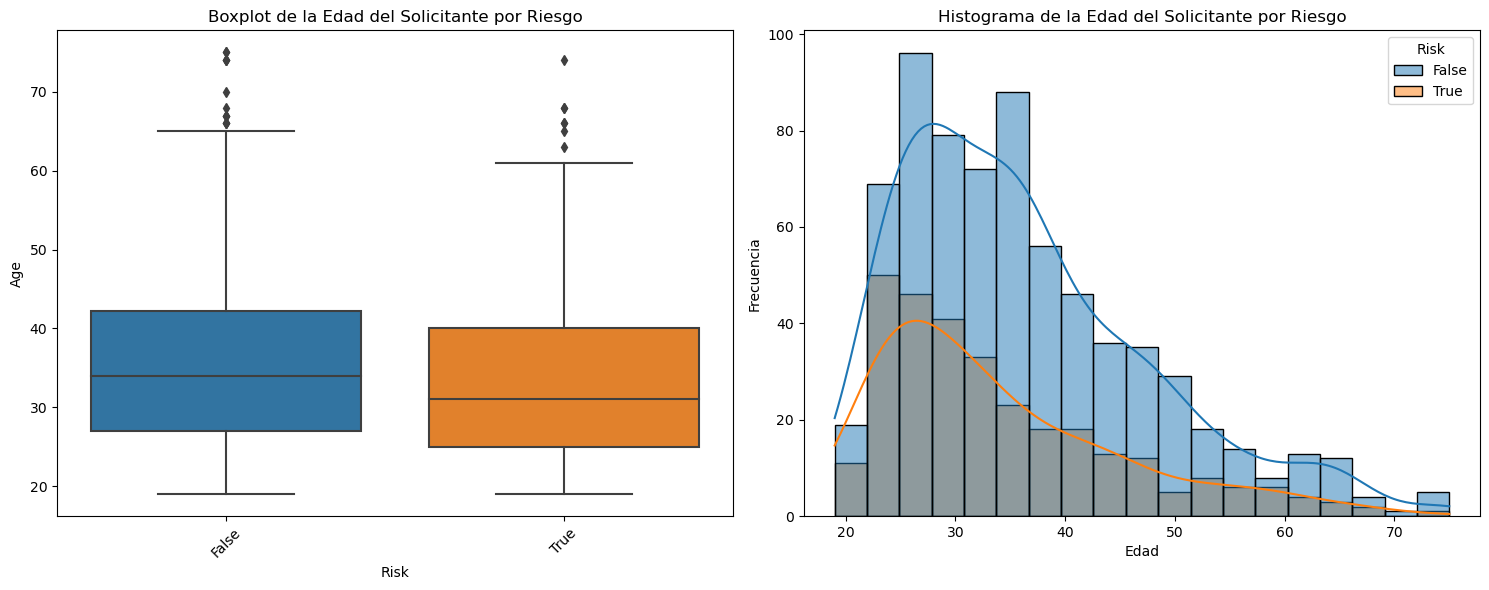

In [129]:
plt.figure(figsize=(15, 6))

# Boxplot
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, primera posición
sns.boxplot(x='Risk', y='Age', data=data)
plt.xticks(rotation=45)
plt.title('Boxplot de la Edad del Solicitante por Riesgo')

# Histograma
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, segunda posición
sns.histplot(x='Age', data=data, hue='Risk', kde=True)
plt.title('Histograma de la Edad del Solicitante por Riesgo')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.tight_layout() # Ajusta automáticamente la disposición de las subgráficas
plt.show()


Creo que no hay necesidad de quitar los outliers pues no son errores de medición sino datos válidos pero extremos.

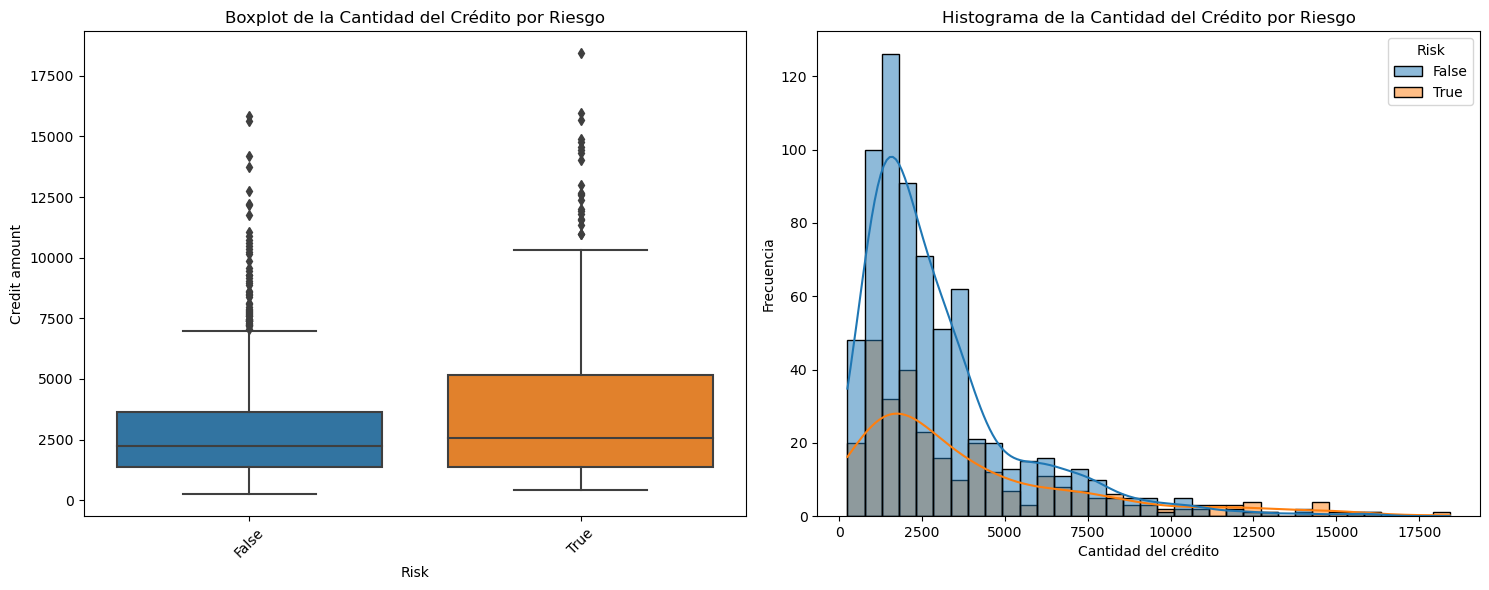

In [130]:
plt.figure(figsize=(15, 6))

# Boxplot
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, primera posición
sns.boxplot(x='Risk', y='Credit amount', data=data)
plt.xticks(rotation=45)
plt.title('Boxplot de la Cantidad del Crédito por Riesgo')

# Histograma
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, segunda posición
sns.histplot(x='Credit amount', data=data, hue='Risk', kde=True)
plt.title('Histograma de la Cantidad del Crédito por Riesgo')
plt.xlabel('Cantidad del crédito')
plt.ylabel('Frecuencia')

plt.tight_layout() # Ajusta automáticamente la disposición de las subgráficas
plt.show()


Creo que no hay necesidad de quitar los outliers pues no son errores de medición sino datos válidos pero extremos.

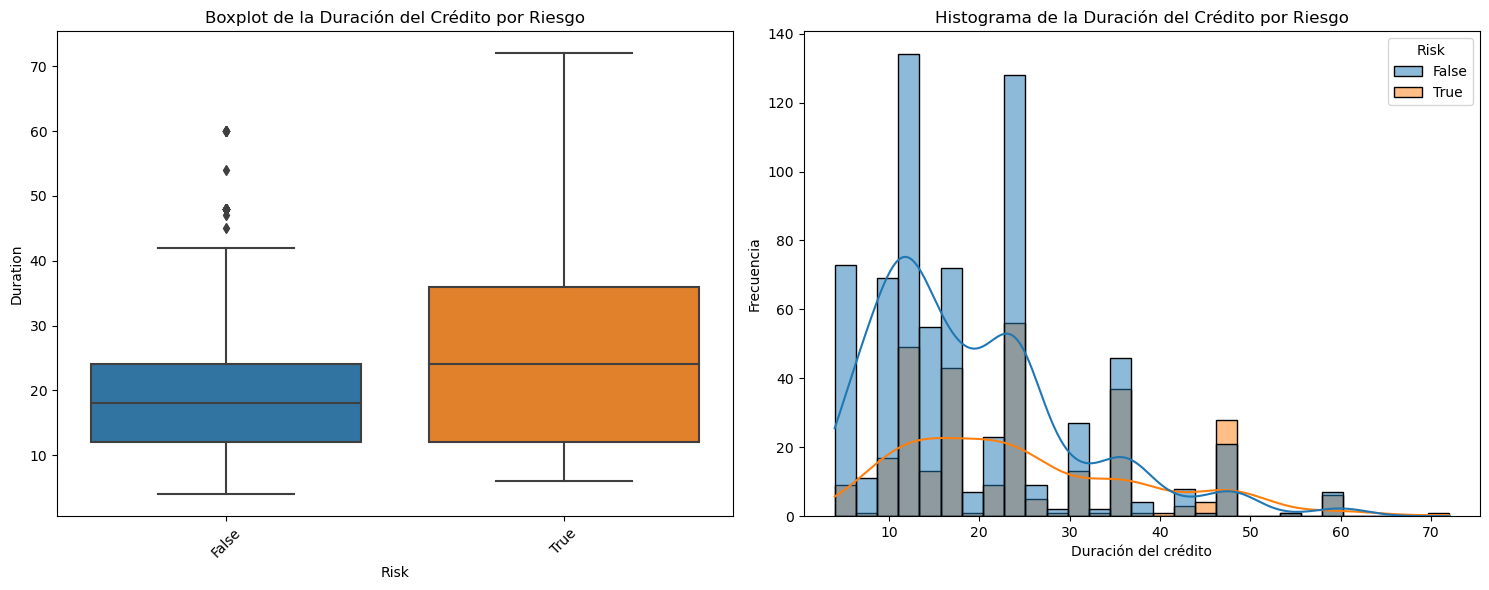

In [131]:
plt.figure(figsize=(15, 6))

# Boxplot
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, primera posición
sns.boxplot(x='Risk', y='Duration', data=data)
plt.xticks(rotation=45)
plt.title('Boxplot de la Duración del Crédito por Riesgo')

# Histograma
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, segunda posición
sns.histplot(x='Duration', data=data, hue='Risk', kde=True)
plt.title('Histograma de la Duración del Crédito por Riesgo')
plt.xlabel('Duración del crédito')
plt.ylabel('Frecuencia')

plt.tight_layout() # Ajusta automáticamente la disposición de las subgráficas
plt.show()


Tal vez sí puede tener sentido eliminar outliers de good Risk, pero no lo tengo claro.

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   int64 
 5   Checking account  1000 non-null   int64 
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   bool  
dtypes: bool(1), int64(6), object(3)
memory usage: 71.4+ KB


# Feature Engineering
## Análisis Exploratorio de Datos (EDA)

Ya hemos visto arriba la distribución de las variables numéricas. A continuación vamos a ver la distribución de las variables categóricas.

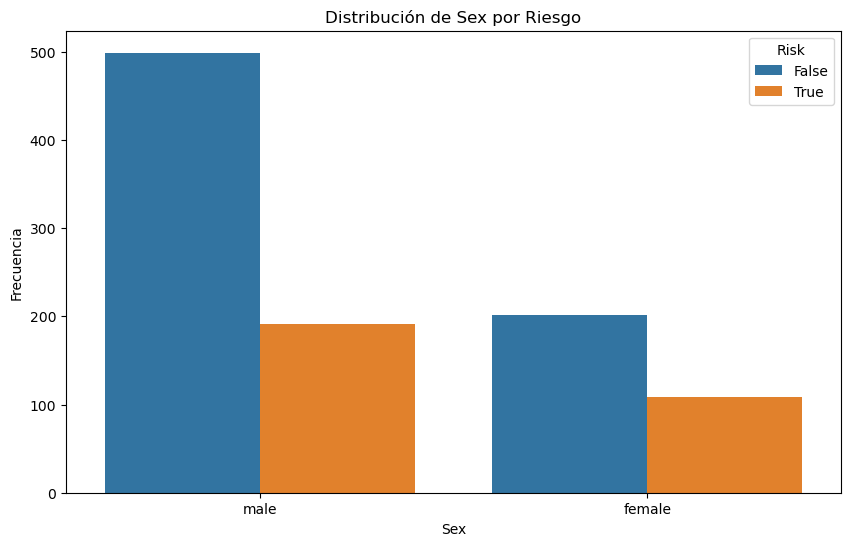

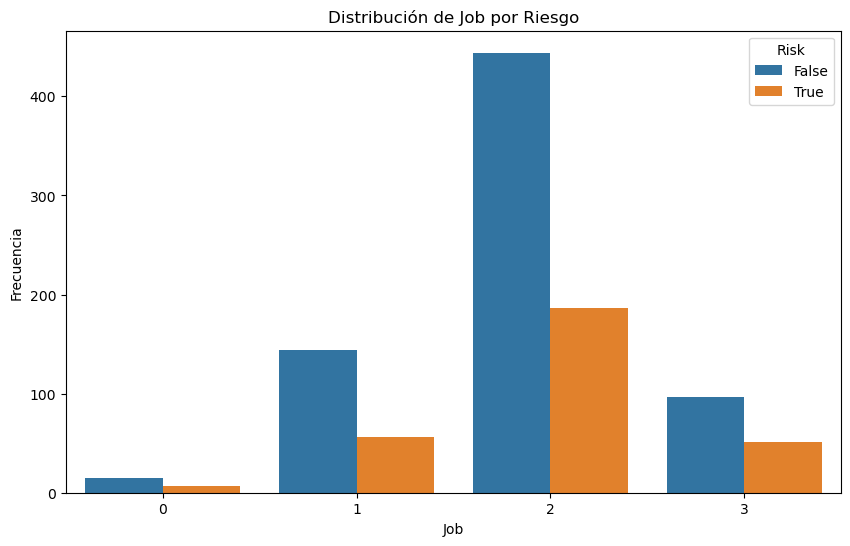

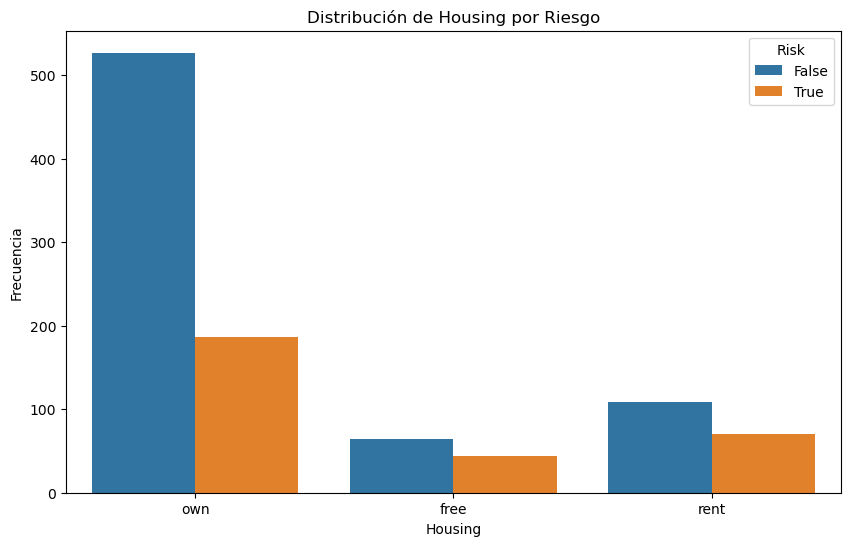

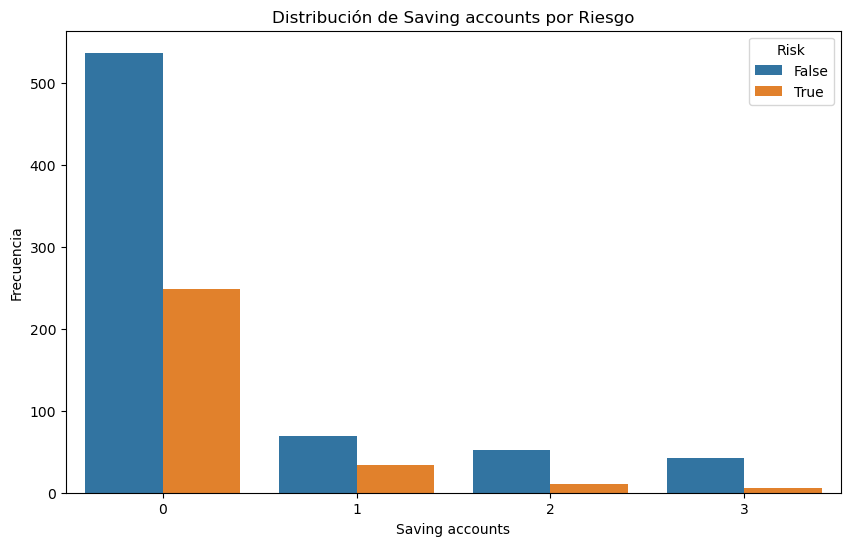

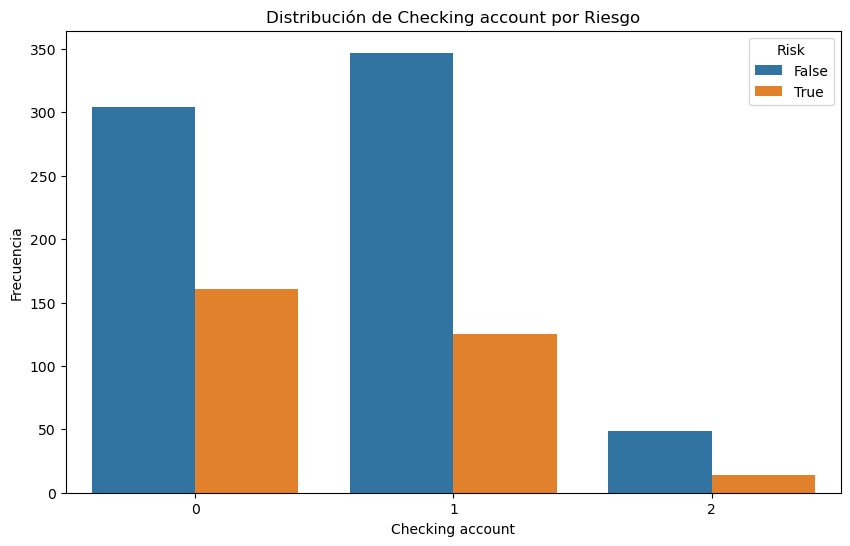

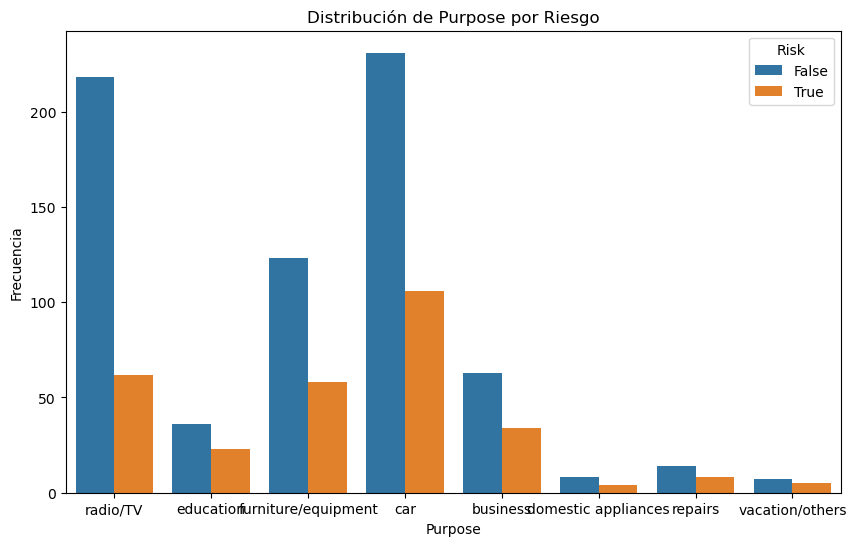

In [133]:
categorical_variables = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Generar gráficos de barras para cada variable categórica
for variable in categorical_variables:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=variable, hue='Risk', data=data)
    plt.title(f'Distribución de {variable} por Riesgo')
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')
    plt.legend(title='Risk', loc='upper right')
    plt.show()

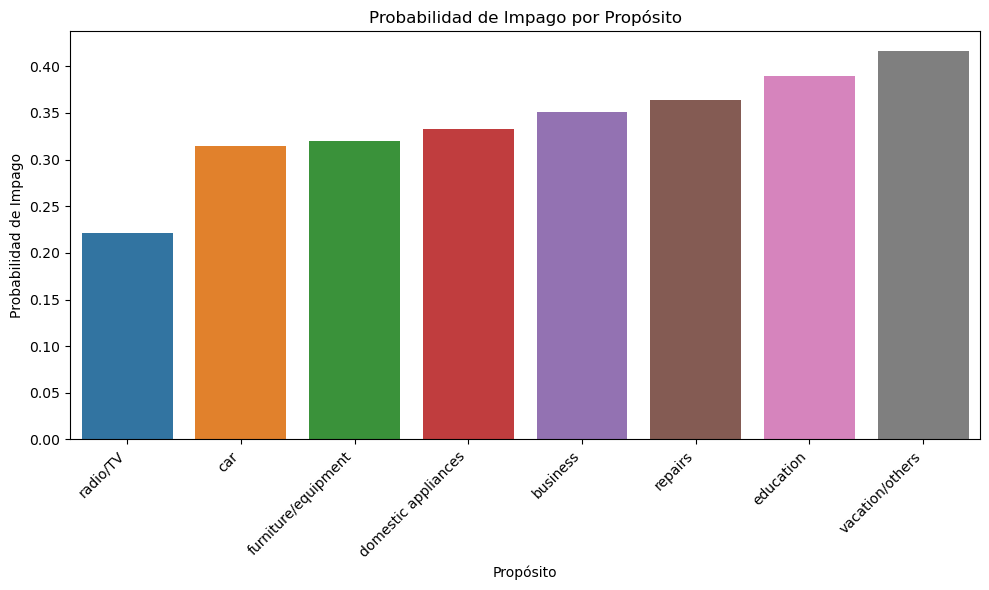

In [134]:
# Calcular la proporción de impago para cada propósito
purpose_default_prob = data.groupby('Purpose')['Risk'].mean().sort_values()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=purpose_default_prob.index, y=purpose_default_prob.values)
plt.title('Probabilidad de Impago por Propósito')
plt.xlabel('Propósito')
plt.ylabel('Probabilidad de Impago')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Correlación Pearson

Observamos la matriz de correlación de las variables numéricas.

/tmp/ipykernel_83/136958227.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(method='pearson'),


<AxesSubplot: >

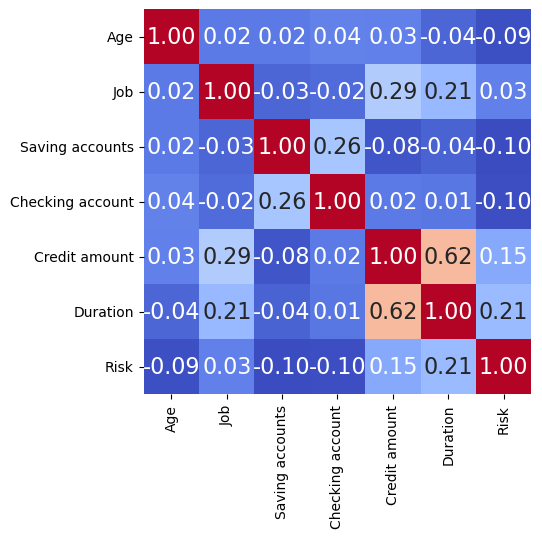

In [135]:
plt.figure(figsize=(5,5))
sns.heatmap(data.corr(method='pearson'),
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            annot_kws={'size':16},
            cbar=False)

Vemos bastante correlación entre la cantidad y la duración del préstamo. 

### Correlation Ratio

Observamos la correlación de las variables numéricas y categóricas.

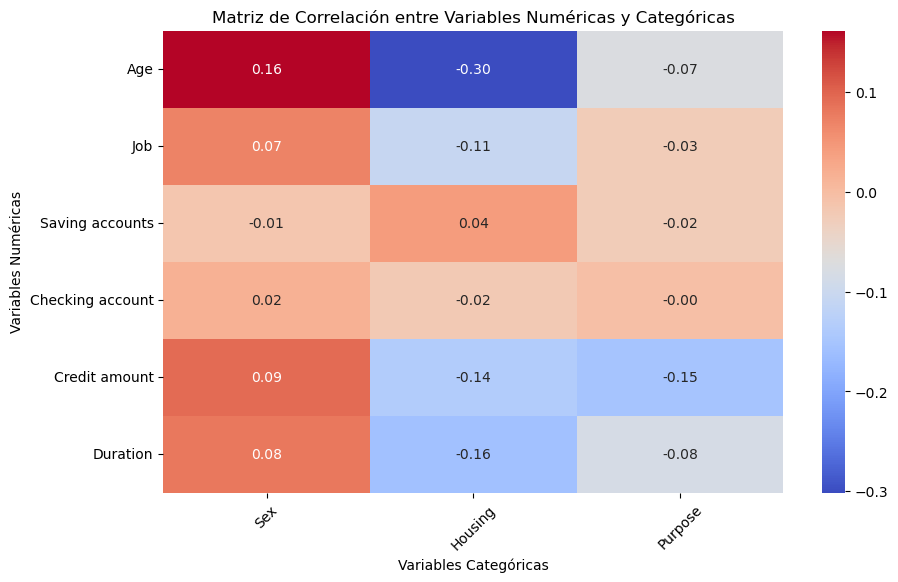

In [136]:
# Seleccionar variables numéricas y categóricas
numeric_data = data.select_dtypes(include=['int64', 'float64'])
categorical_data = data.select_dtypes(include=['object'])

# Copiar el dataframe para evitar modificar el original
data_df = data.copy()

# Convertir variables categóricas a numéricas utilizando LabelEncoder
le = preprocessing.LabelEncoder()
for categorical_column in categorical_data.columns:
    data_df[categorical_column] = le.fit_transform(data_df[categorical_column])

# Inicializar una matriz para almacenar los coeficientes de correlación
correlation_matrix = np.zeros((len(numeric_data.columns), len(categorical_data.columns)))

# Calcular correlation ratio entre variables numéricas y categóricas
for i, numeric_column in enumerate(numeric_data.columns):
    for j, categorical_column in enumerate(categorical_data.columns):
        correlation = stats.pointbiserialr(data_df[categorical_column], data_df[numeric_column])[0]
        correlation_matrix[i, j] = correlation

# Crear un DataFrame a partir de la matriz de correlación
correlation_df = pd.DataFrame(correlation_matrix, index=numeric_data.columns, columns=categorical_data.columns)

# Mostrar la matriz de correlación con colores
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={'size': 10})
plt.title('Matriz de Correlación entre Variables Numéricas y Categóricas')
plt.xlabel('Variables Categóricas')
plt.ylabel('Variables Numéricas')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

### Correlación Cramer

Observamos la matriz de correlación de las variables categóricas.

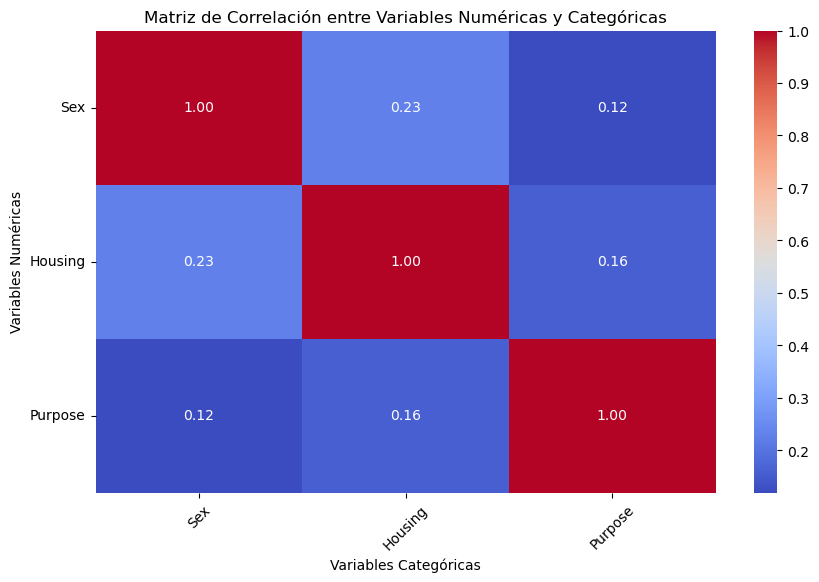

In [137]:
def cramers_v(confusion_matrix):
    """ Calculate Cramer's V statistic for categorical-categorical association.
        Uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328.
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Obtener las variables categóricas
categorical_columns = data.select_dtypes(include=['object']).columns

# Calcular el coeficiente de Cramer para todas las combinaciones de variables categóricas
cramer_matrix = np.zeros((len(categorical_columns), len(categorical_columns)))

for i, col1 in enumerate(categorical_columns):
    for j, col2 in enumerate(categorical_columns):
        if i == j:
            cramer_matrix[i, j] = 1.0
        else:
            confusion_matrix = pd.crosstab(data[col1], data[col2]).values
            cramer_matrix[i, j] = cramers_v(confusion_matrix)

# Crear un DataFrame a partir de la matriz de coeficientes de Cramer
cramer_df = pd.DataFrame(cramer_matrix, index=categorical_columns, columns=categorical_columns)

# Mostrar la matriz de correlación con colores
plt.figure(figsize=(10, 6))
sns.heatmap(cramer_df, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={'size': 10})
plt.title('Matriz de Correlación entre Variables Categóricas')
plt.xlabel('Variables Categóricas')
plt.ylabel('Variables Numéricas')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Selección de características
Realmente ya ha sido hecho por la persona que subió la base de datos y que redujo de 20 a 10 características.

## Transformación de características

Normalizamos características numéricas para que tengan una escala común. Resulta útil si queremos comparar características.

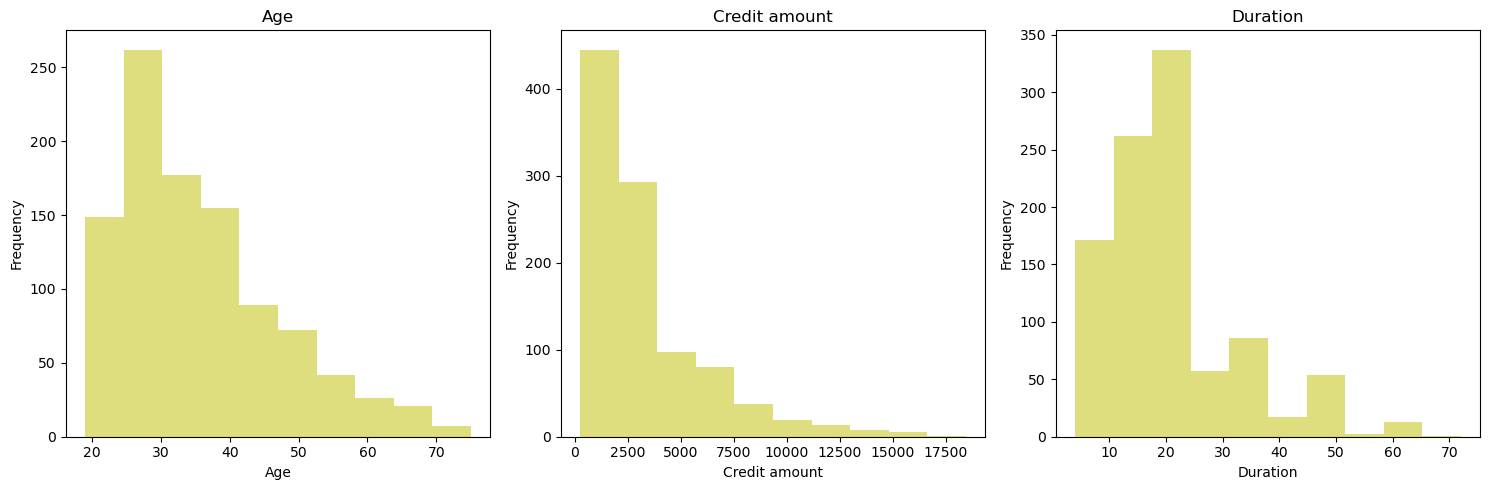

3 variables have been plotted


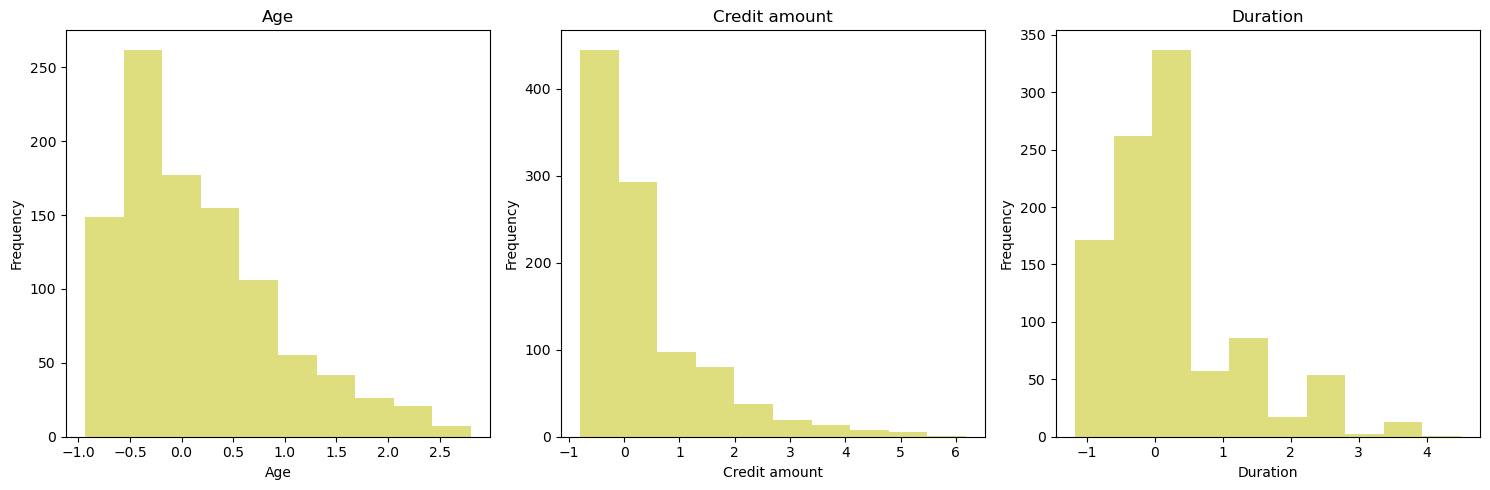

3 variables have been plotted


In [138]:
# Función para mostrar las gráficas
def hist_for_nums(data, numeric_cols):
    col_counter = 0
    data = data.copy()
    num_cols = len(numeric_cols)
    fig, axes = plt.subplots(1, num_cols, figsize=(15, 5))
    for i, col in enumerate(numeric_cols):
        data[col].plot.hist(alpha=0.5, color='y', ax=axes[i])
        axes[i].set_xlabel(col)
        axes[i].set_title(col)
        col_counter += 1
    plt.tight_layout()
    plt.show()
    print(col_counter, "variables have been plotted")

# Lista con los nombres de las variables numéricas no categóricas con más de 20 valores
like_num = [col for col in data.columns if data[col].dtypes != 'O' and len(data[col].value_counts()) > 20]

# Quitamos id, risk y las que tienen menos de 20 valores
cols_need_scale = [col for col in like_num if col not in ["Id","Risk"]]

hist_for_nums(data, cols_need_scale)    

# Función para estandarizar variables
def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

data_encoded = data.copy()
for col in cols_need_scale:
    data_encoded[col] = robust_scaler(data_encoded[col])

data_encoded[cols_need_scale].head()
data_encoded[cols_need_scale].describe().T
hist_for_nums(data_encoded, cols_need_scale)

In [139]:
# Aplicar one-hot encoding a las variables categóricas
data_encoded = pd.get_dummies(data_encoded, columns=['Job','Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk'] , drop_first=True)

# drop_first=True para evitar la multicolinealidad, eliminando una columna redundante de cada conjunto de dummies

# Mostrar las primeras filas del nuevo conjunto de datos
print(data_encoded.head())


     Age  Credit amount  Duration  Job_1  Job_2  Job_3  Sex_male  Housing_own  \
0  2.267         -0.441      -1.0      0      1      0         1            1   
1 -0.733          1.393       2.5      0      1      0         0            1   
2  1.067         -0.086      -0.5      1      0      0         1            1   
3  0.800          2.134       2.0      0      1      0         1            0   
4  1.333          0.978       0.5      0      1      0         1            0   

   Housing_rent  Saving accounts_1  ...  Checking account_1  \
0             0                  0  ...                   0   
1             0                  0  ...                   1   
2             0                  0  ...                   0   
3             0                  0  ...                   0   
4             0                  0  ...                   0   

   Checking account_2  Purpose_car  Purpose_domestic appliances  \
0                   0            0                            0   


<AxesSubplot: >

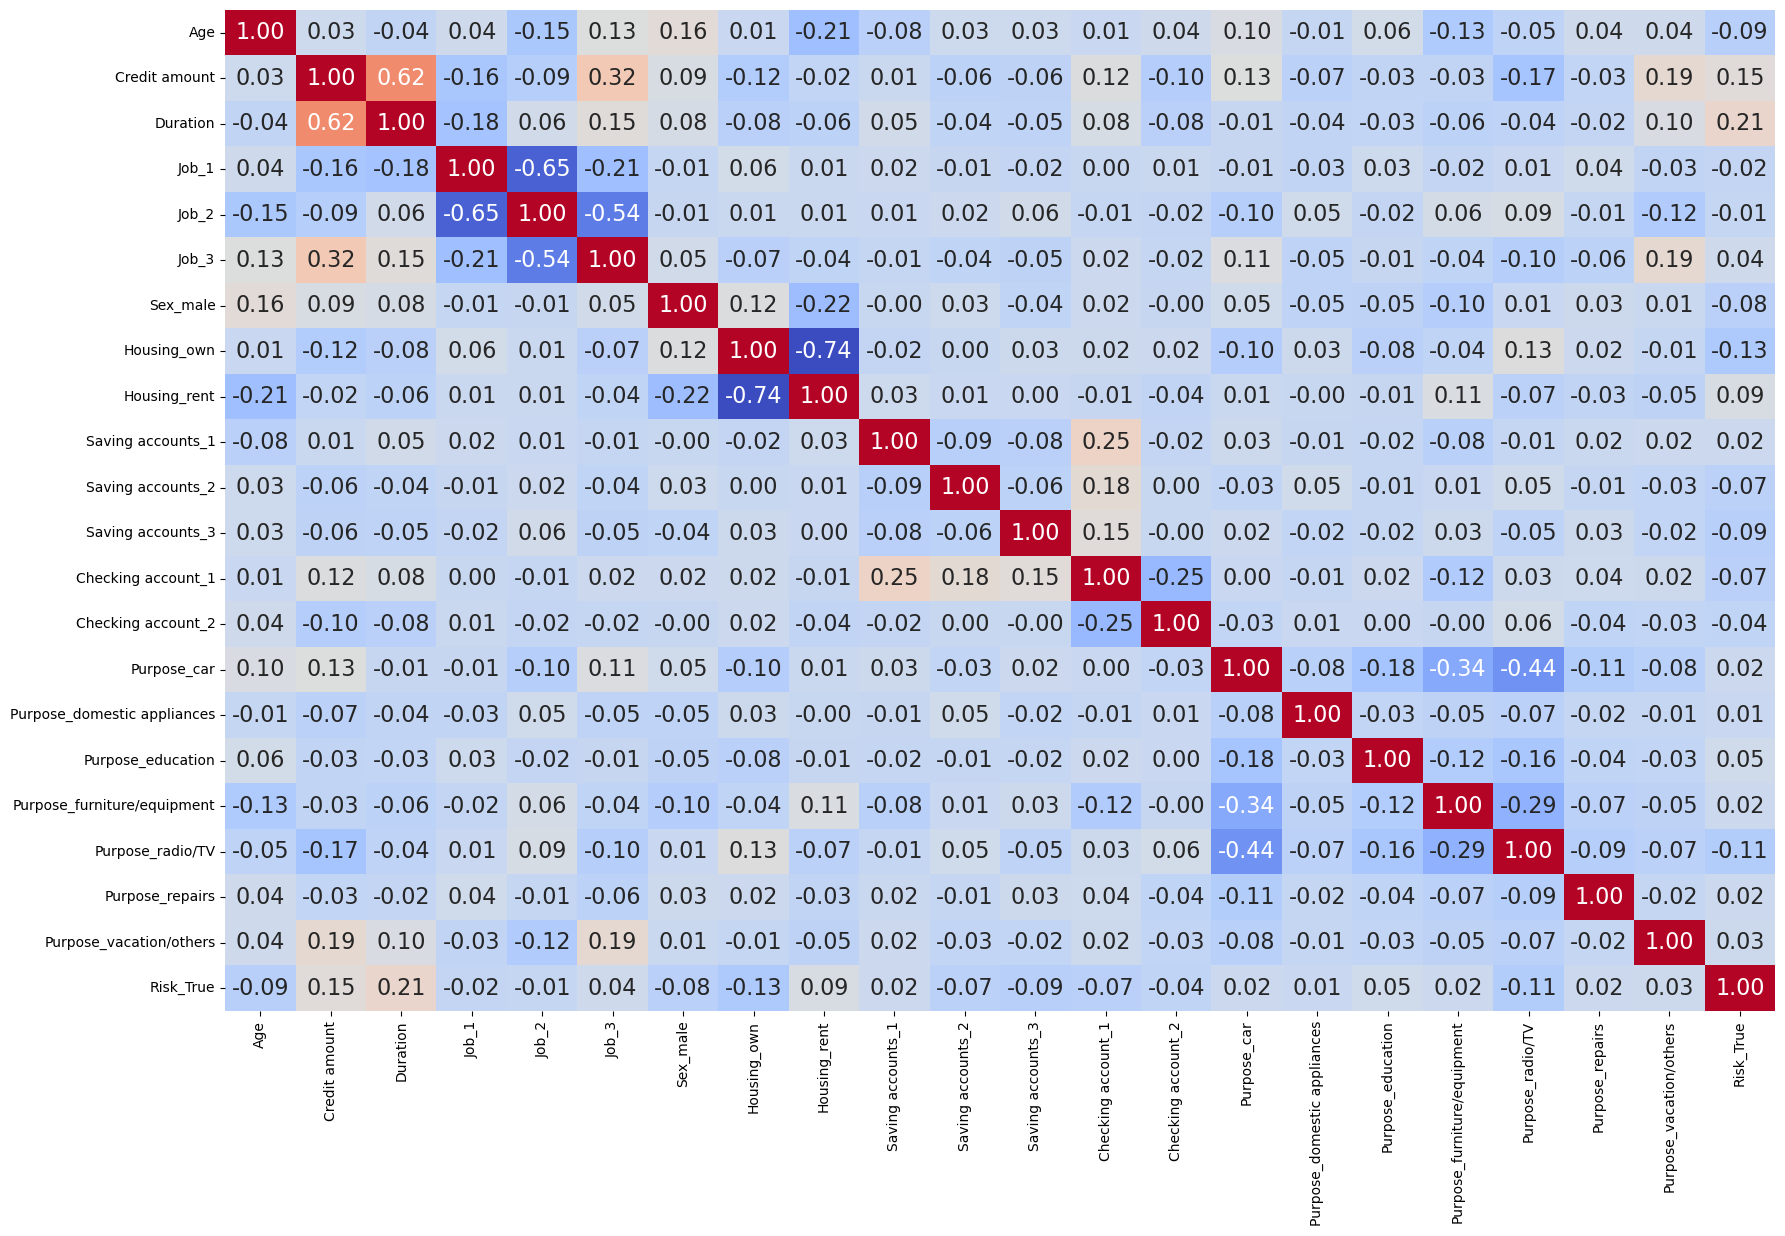

In [140]:
plt.figure(figsize=(20,13))
sns.heatmap(data_encoded.corr(),
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            annot_kws={'size':16},
            cbar=False)

# Guardamos los datos
Guardo los datos en un fichero para entrenar los modelos directamente en python.

In [141]:
nombre_archivo = "GermanRisk/german_credit_data_prepared.csv"

# Guardar los datos preparados en un archivo CSV
data_encoded.to_csv(nombre_archivo, index=False)

# Interpretación Naive

La interpretación general que doy es la siguiente:
 - Dado que la base de datos ya estaba bastante preparada, todas las variables aportan a la predicción, siendo claramente las más importantes la cantidad del préstamo y la duracción.
 - La cantidad del préstamo y la duracción afectan negativamente a la predicción, es decir los préstamos más grandes y más largos tienen mayor riesgo. Estas dos variables están correlacionadas lo cual es lógico. Habría que tener en cuenta como comentamos que hay que relativizar los impagos de larga duración pues no es lo mismo un impago de 30 años que un impago de 6 meses. Pero en general estas dos variables son las que más afectan a la predicción.
 - Las variables como ahorros, dinero en la cuenta, si tienen casa o viven de alquiler, el tipo de trabajo resultan totalmente intuitivos, cuanto mejor la situación (más ahorros, más dinero en la cuenta, tener casa en vez de vivir de alquiler...) menos riego de impago.
 - La edad disminuye el riesgo de impago, tiene sentido si pensamos que la gente mayor es más sensata, arriesga menos que los jóvenes y suelen tener mayor estabilidad financiera.
 - Es curioso el caso de que ser hombre disminuye el riesgo de impago, debe haber muchos factores involucrados pero me sorprende porque creo que en general los hombres suelen ser más agresivos en las finanzas.
 - Finalmente el motivo también afecta al riesgo, esta es la variable más difícil de intuir. En mi opinión, parece que tiene sentido que gastos menores o más necesarios tengan menos riesgo como puede ser la necesidad de un coche para trabajar o un gasto menor como puede ser una radio (relación con cantidad de préstamo como  hemos comentado), y tiene sentido que propósitos como vacaciones que son secundarios (y que no deberías pedir un préstamo para ellos, parece que es querer vivir por encima de su nivel financiero) aumenten la probabilidad de impago. Aún así no me encaja el propósito de educación, creo que puede ser que esté afectado por el abandono de los estudios.

# Entrenamiento de modelos de clasificación

In [1]:
import random
import sys
sys.path.append('../../')
import Modelos
import pandas as pd
from sklearn.model_selection import train_test_split
random.seed(6)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
nombre_archivo = "../../../GermanRisk/german_credit_data_prepared.csv"

datos_leidos = pd.read_csv(nombre_archivo)

In [3]:
# Dividir los datos en características (X) y etiquetas (y)
X = datos_leidos.drop('Risk_True', axis=1)  # Características
y = datos_leidos['Risk_True']  # Etiquetas

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Reporte de clasificación (Classification Report) por clases**:

**Precision (Precisión)**: Es la proporción de verdaderos positivos sobre el total de predicciones positivas hechas por el modelo.

**Recall (Recuperación o Sensibilidad)**: Es la proporción de verdaderos positivos sobre el total de casos positivos reales en el conjunto de datos.

**F1-score**: Es una medida que combina tanto la precisión como el recall en una sola métrica. Es útil cuando hay un desequilibrio entre las clases. Un F1-score alto indica un buen equilibrio entre precisión y recall.

**Support**: Es el número de muestras reales en cada clase en el conjunto de datos de prueba.

**Macro avg y weighted avg**: Son promedios de las métricas de precision, recall y f1-score, calculados de diferentes maneras. Macro avg calcula el promedio no ponderado de las métricas para todas las clases. Weighted avg calcula el promedio ponderado por el número de muestras en cada clase. En este caso, el macro avg y weighted avg para precision, recall y f1-score son similares debido a un equilibrio relativamente uniforme entre las clases.

## Regresión Logística

In [4]:
rg_lg = Modelos.resultados_regresion_logistica(X_train, y_train, X_test, y_test)


Regresión Logística:

Regresión Logística en conjunto de test:
Precisión: 0.72
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       141
           1       0.56      0.24      0.33        59

    accuracy                           0.72       200
   macro avg       0.65      0.58      0.58       200
weighted avg       0.69      0.72      0.68       200



## Gradient Boost

Primero con buscamos en todo un grid para tener una estimación de los mejores hiperparámetros.

In [13]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [3, 4, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0]
}

# Inicializar el clasificador GradientBoosting
gb_clf = GradientBoostingClassifier()

best_params = Modelos.optimizar_modelo_clasificacion("DecisionTree", gb_clf, param_grid, X_train, y_train, X_test, y_test)


DecisionTree:
Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
Mejores hiperparámetros encontrados:
{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.6}

Precisión del modelo en el conjunto de test: 0.725
Reporte de clasificación en el conjunto de test:
              precision    recall  f1-score   support

           0       0.73      0.97      0.83       141
           1       0.67      0.14      0.23        59

    accuracy                           0.73       200
   macro avg       0.70      0.55      0.53       200
weighted avg       0.71      0.72      0.65       200



Ahora buscamos los mejores hiperparámetros en ese entorno.

In [24]:
param_grid = {
    "learning_rate": [0.05, 0.1, 0.15],
    "n_estimators": [30, 50, 100, 125, 150, 175, 200],
    "max_depth": [2, 3, 4, 5],
    'min_samples_split': [3, 4, 5, 6, 7],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6],
    'subsample': [0.65, 0.6, 0.75, 0.8]
}

# Inicializar el clasificador GradientBoosting
gb_clf = GradientBoostingClassifier()

gb_clf = Modelos.optimizar_modelo_clasificacion("DecisionTree", gb_clf, param_grid, X_train, y_train, X_test, y_test)


DecisionTree:
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits
Mejores hiperparámetros encontrados:
{'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 7, 'n_estimators': 30, 'subsample': 0.6}

Precisión del modelo en el conjunto de test: 0.73
Reporte de clasificación en el conjunto de test:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83       141
           1       0.65      0.19      0.29        59

    accuracy                           0.73       200
   macro avg       0.69      0.57      0.56       200
weighted avg       0.71      0.73      0.67       200



## Random Forest

In [14]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Inicializar el clasificador Random Forest
rf_clf = RandomForestClassifier()
rf_clf = Modelos.optimizar_modelo_clasificacion("RandomForest", rf_clf, param_grid, X_train, y_train, X_test, y_test)


RandomForest:
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/gregorio/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
150 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gregorio/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gregorio/.local/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/gregorio/.local/lib/python3.8/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/home/gregori

Mejores hiperparámetros encontrados:
{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

Precisión del modelo en el conjunto de test: 0.725


In [25]:
param_grid = {
    'n_estimators': [100, 125, 150, 175, 200, 250],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [8, 9, 10, 11, 15, 20],
    'min_samples_split': [3, 4, 5, 7, 9],
    'min_samples_leaf': [1, 3, 4, 5],
    'bootstrap': [True, False]
}

# Inicializar el clasificador Random Forest
rf_clf = RandomForestClassifier()
rf_clf = Modelos.optimizar_modelo_clasificacion("RandomForest", rf_clf, param_grid, X_train, y_train, X_test, y_test)


RandomForest:
Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


/home/gregorio/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gregorio/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
7200 fits failed out of a total of 21600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5236 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gregorio/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gregorio/.local/l

Mejores hiperparámetros encontrados:
{'bootstrap': True, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 150}

Precisión del modelo en el conjunto de test: 0.72
Reporte de clasificación en el conjunto de test:
              precision    recall  f1-score   support

           0       0.73      0.95      0.83       141
           1       0.59      0.17      0.26        59

    accuracy                           0.72       200
   macro avg       0.66      0.56      0.55       200
weighted avg       0.69      0.72      0.66       200



### Red neuronal HE DEJADO UN ANEXO CON KERAS QUE NO HA FUNCIONADO BIEN

### Modelos obtenidos

GUARDAR Y CARGAR CON PICKLE

In [1]:
# Imports necesarios
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import random
random.seed(6)

nombre_archivo = "../../../GermanRisk/german_credit_data_prepared.csv"
datos_leidos = pd.read_csv(nombre_archivo)

# Dividir los datos en características (X) y etiquetas (y)
X = datos_leidos.drop('Risk_True', axis=1)  # Características
y = datos_leidos['Risk_True']  # Etiquetas

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rg_lg = LogisticRegression(max_iter=1000)
rg_lg.fit(X_train, y_train)


gb_clf = GradientBoostingClassifier(learning_rate=0.05,
                                     max_depth=5,
                                     min_samples_leaf=6,
                                     min_samples_split=7,
                                     n_estimators=30,
                                     subsample=0.6)
gb_clf.fit(X_train, y_train)

rf_clf = RandomForestClassifier(bootstrap=True,
                                 max_depth=11,
                                 max_features='sqrt',
                                 min_samples_leaf=4,
                                 min_samples_split=10,
                                 n_estimators=100)
rf_clf.fit(X_train, y_train)

# Define y configura el modelo MLP
mlp_clf = MLPClassifier(hidden_layer_sizes=(9, 9),
                          activation='relu',
                          solver='adam',
                          random_state=42,
                          max_iter=1000)

# Entrena el modelo con los datos de entrenamiento
mlp_clf.fit(X_train, y_train)

# Serialize the object to a binary format
with open('rg_lg.pkl', 'wb') as file:
    pickle.dump(rg_lg, file)

# Serialize the object to a binary format
with open('gb_clf.pkl', 'wb') as file:
    pickle.dump(gb_clf, file)

# Serialize the object to a binary format
with open('rf_clf.pkl', 'wb') as file:
    pickle.dump(rf_clf, file)

# Serialize the object to a binary format
with open('mlp_clf.pkl', 'wb') as file:
    pickle.dump(mlp_clf, file)

print('Preparado')

Preparado


/home/gregorio/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


## Optimizar Umbrales

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import Umbrales

### Regresión Logística

In [36]:
clf=rg_lg

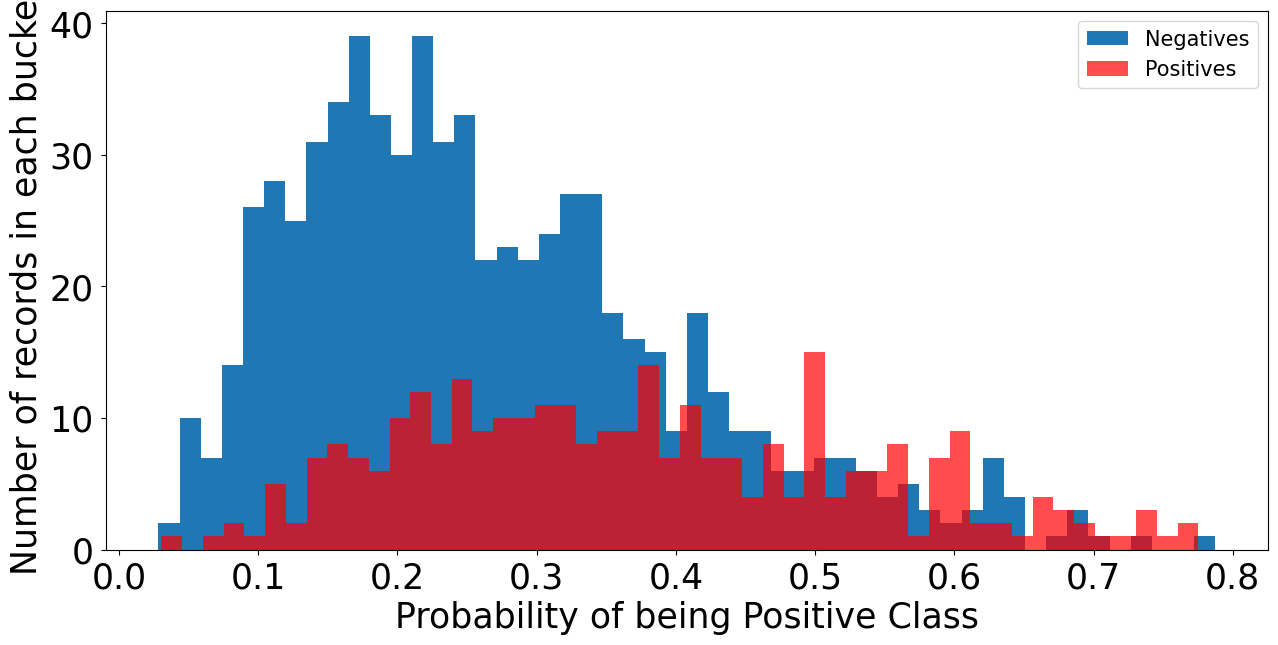

In [37]:
Umbrales.plot_prob(clf, X, y)


Precisión con umbral nuevo: 0.712
Informe de clasificación con umbral nuevo:
              precision    recall  f1-score   support

           0       0.72      0.96      0.82       700
           1       0.58      0.14      0.23       300

    accuracy                           0.71      1000
   macro avg       0.65      0.55      0.53      1000
weighted avg       0.68      0.71      0.64      1000



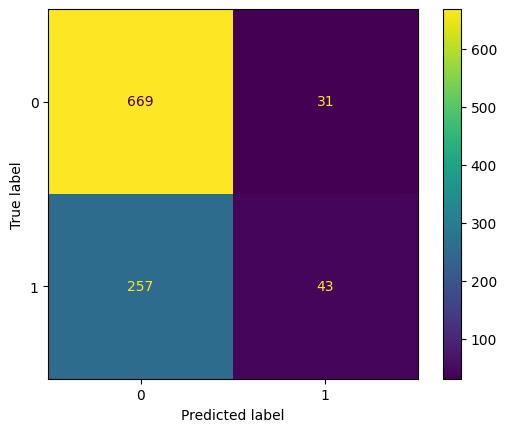

In [38]:
Umbrales.report_umbral(0.56, clf, X, y)

### Árbol de Decisión

In [39]:
clf=gb_clf

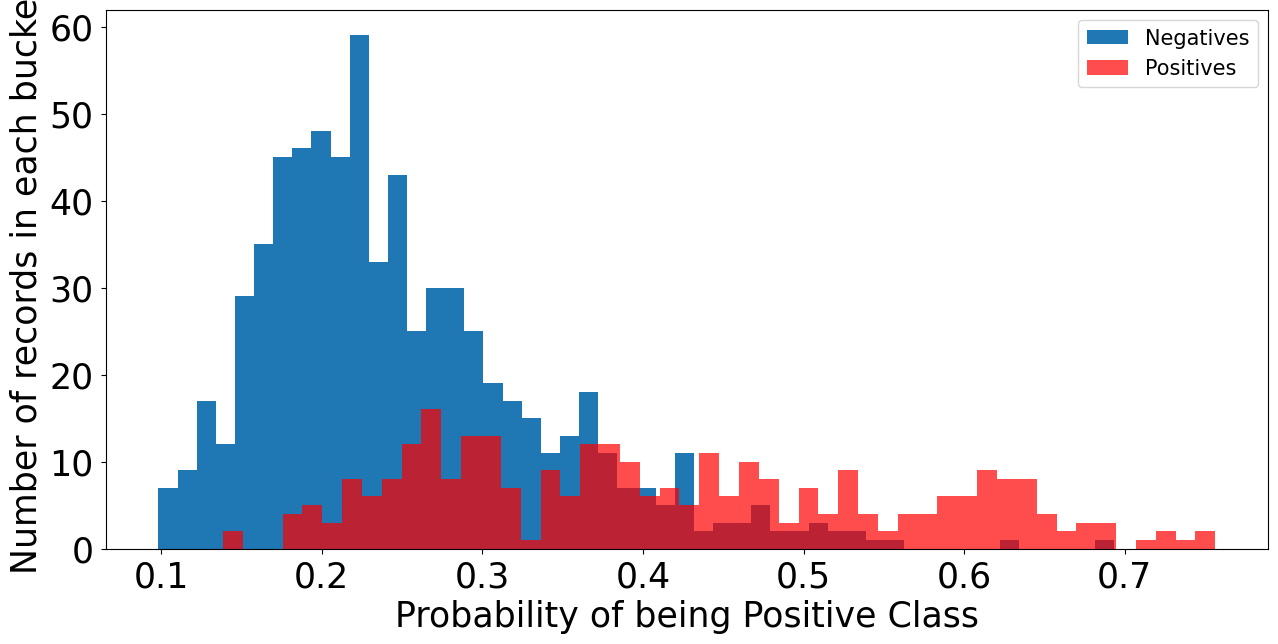

In [40]:
Umbrales.plot_prob(clf, X, y)


Precisión con umbral nuevo: 0.789
Informe de clasificación con umbral nuevo:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       700
           1       0.82      0.38      0.52       300

    accuracy                           0.79      1000
   macro avg       0.80      0.67      0.69      1000
weighted avg       0.79      0.79      0.76      1000



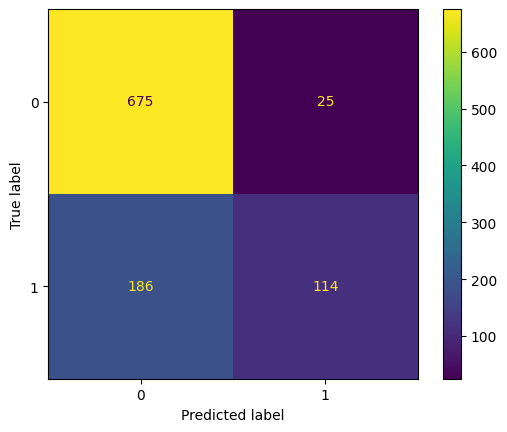

In [41]:
Umbrales.report_umbral(0.45, clf, X, y)

### Random Forest

In [42]:
clf=rf_clf

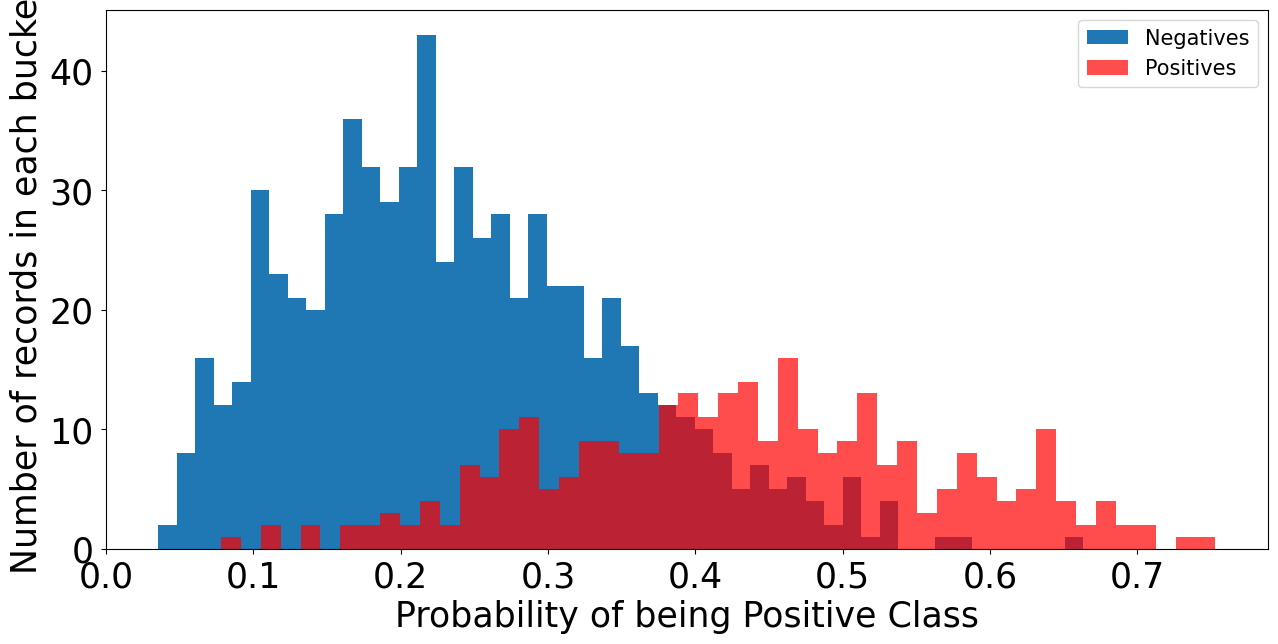

In [43]:
Umbrales.plot_prob(clf, X, y)


Precisión con umbral nuevo: 0.811
Informe de clasificación con umbral nuevo:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       700
           1       0.68      0.70      0.69       300

    accuracy                           0.81      1000
   macro avg       0.77      0.78      0.78      1000
weighted avg       0.81      0.81      0.81      1000



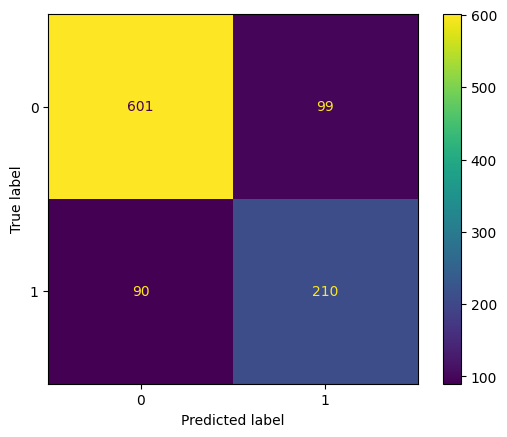

In [44]:
Umbrales.report_umbral(0.36, clf, X, y)

### Red Neuronal

In [48]:
clf=mlp_clf

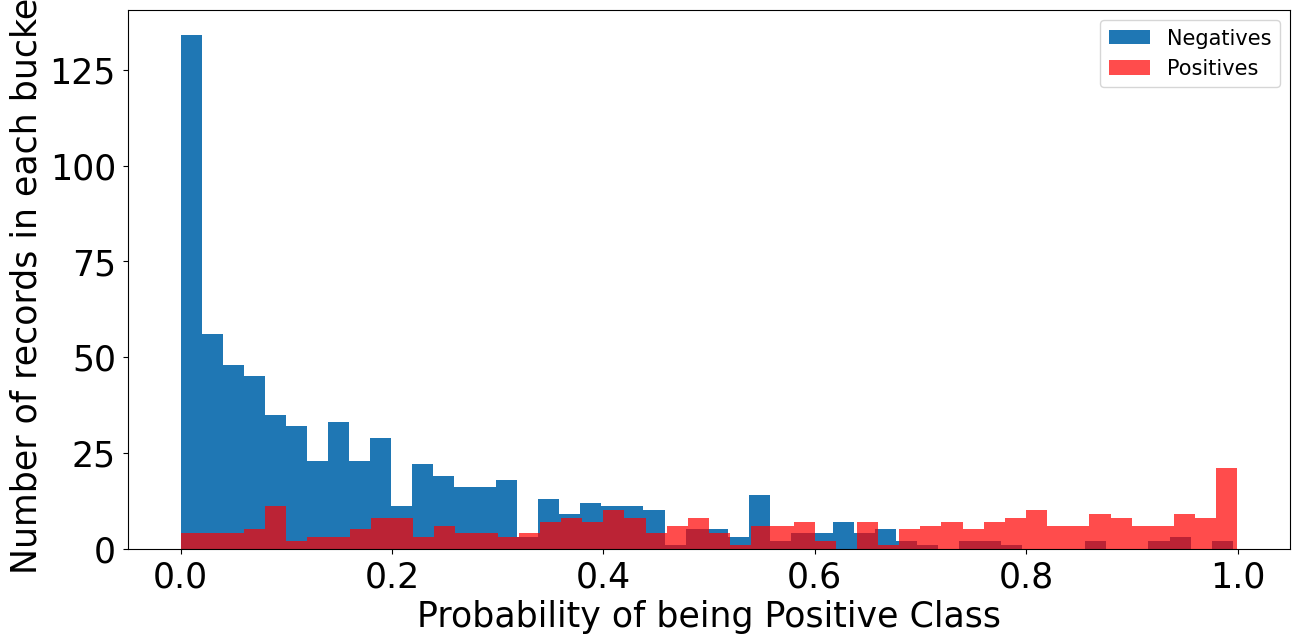

In [49]:
Umbrales.plot_prob(clf, X, y)


Precisión con umbral nuevo: 0.805
Informe de clasificación con umbral nuevo:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       700
           1       0.84      0.43      0.57       300

    accuracy                           0.81      1000
   macro avg       0.82      0.70      0.72      1000
weighted avg       0.81      0.81      0.78      1000



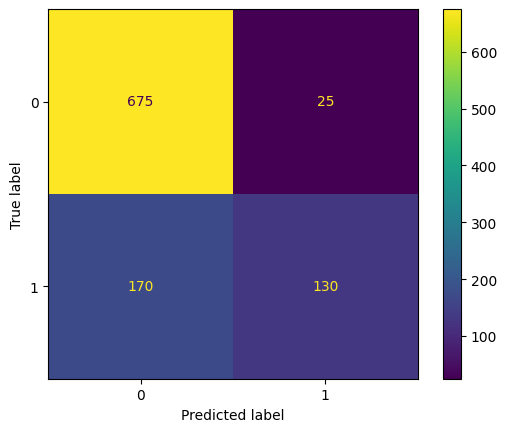

In [58]:
Umbrales.report_umbral(0.65, clf, X, y)


Precisión con umbral nuevo: 0.798
Informe de clasificación con umbral nuevo:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       700
           1       0.69      0.60      0.64       300

    accuracy                           0.80      1000
   macro avg       0.76      0.74      0.75      1000
weighted avg       0.79      0.80      0.79      1000



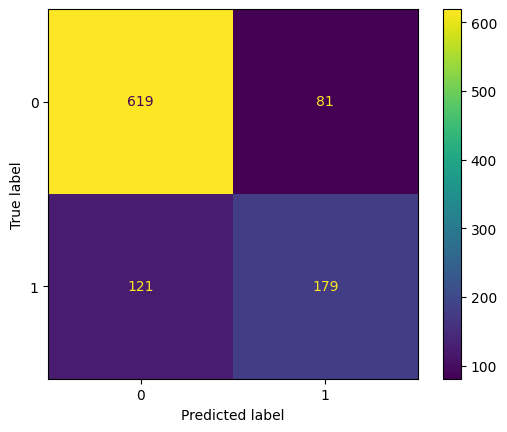

In [59]:
Umbrales.report_umbral(0.44, clf, X, y)

# Comparar Resultados


 - No me sorprende que regresión logística da resultados malos, demasiada mezcla entre positivos y negativos.
 - He empeorado GBM pero como no lo voy a usar no voy a perder el tiempo en esto.
 - Random forest da los mejores resultados tiene una precisión similar a redes neuronales y un recall más alto. Viendo la matriz de confusión vemos que mejor.
 - Redes neuronales con un resultado no demasiado bueno, como he comentado al principio esto se debe a los pocos datos disponibles que hacen que esta no sea una buena base de datos para las redes neuronales.

# Interpretabilidad

In [2]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.inspection import permutation_importance

Cargamos los datos.

In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Cargar el modelo de regresión logística
with open('rg_lg.pkl', 'rb') as file:
    rg_lg = pickle.load(file)

# Cargar el modelo de Gradient Boosting Classifier
with open('gb_clf.pkl', 'rb') as file:
    gb_clf = pickle.load(file)

# Cargar el modelo de Random Forest Classifier
with open('rf_clf.pkl', 'rb') as file:
    rf_clf = pickle.load(file)

# Cargar el modelo de MLP Classifier
with open('mlp_clf.pkl', 'rb') as file:
    mlp_clf = pickle.load(file)

nombre_archivo = "../../../GermanRisk/german_credit_data_prepared.csv"
datos_leidos = pd.read_csv(nombre_archivo)

# Dividir los datos en características (X) y etiquetas (y)
X = datos_leidos.drop('Risk_True', axis=1)  # Características
y = datos_leidos['Risk_True']  # Etiquetas

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## PFI

### Regresión Logística

In [12]:
clf=rg_lg

In [13]:
r = permutation_importance(clf, X, y,
                            n_repeats=30,
                            random_state=0)

Text(0.5, 1.0, 'Permutation Importance')

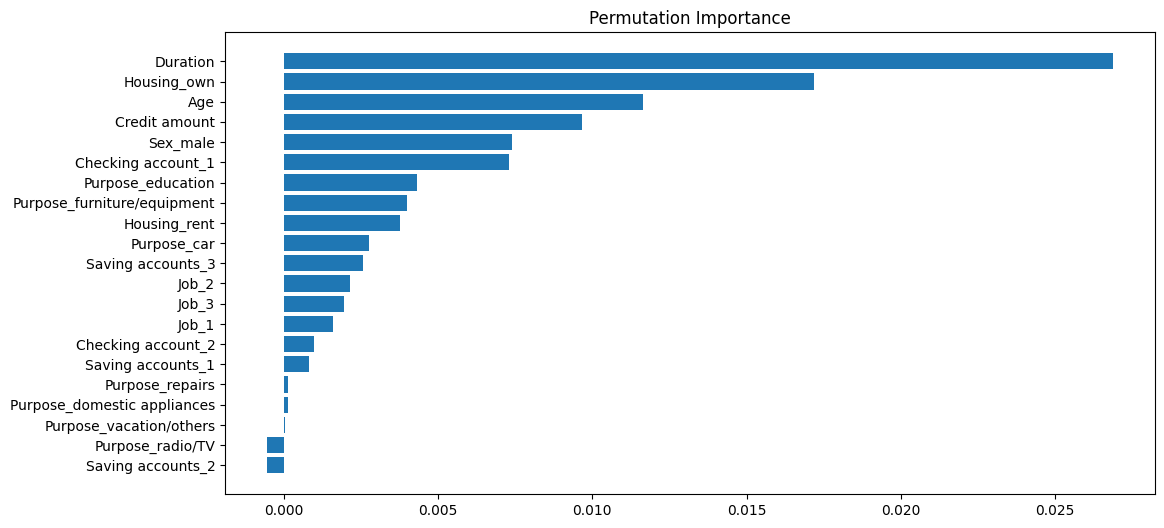

In [14]:
sorted_idx = r.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), r.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance')

### Random Forest

In [16]:
clf=rf_clf

In [17]:
r = permutation_importance(clf, X, y,
                            n_repeats=30,
                            random_state=0)

Text(0.5, 1.0, 'Permutation Importance')

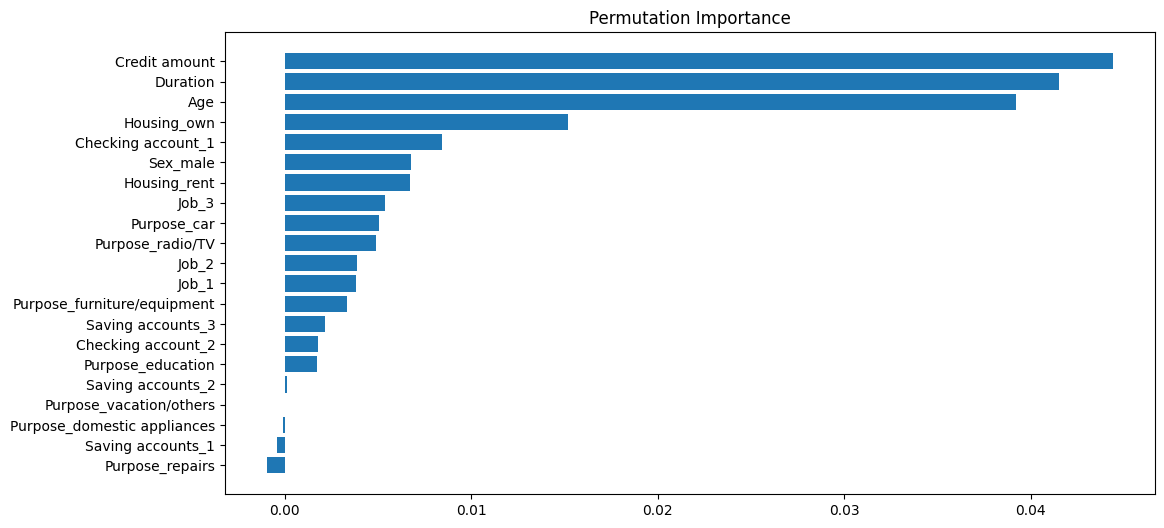

In [18]:
sorted_idx = r.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), r.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance')

### Red neuronal

In [19]:
clf=mlp_clf

In [20]:
r = permutation_importance(clf, X, y,
                            n_repeats=30,
                            random_state=0)

Text(0.5, 1.0, 'Permutation Importance')

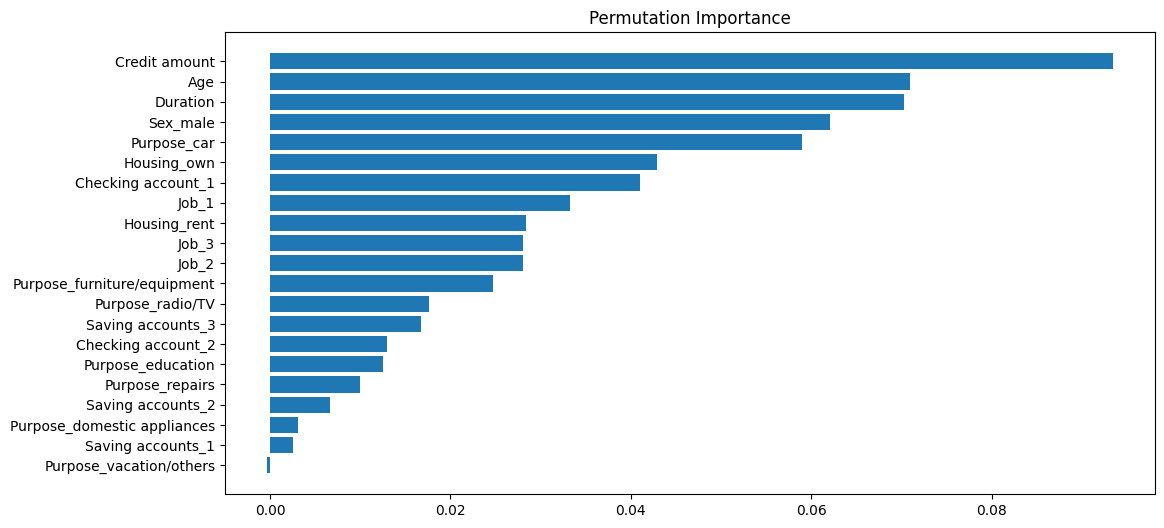

In [21]:
sorted_idx = r.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), r.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance')

Vemos que la variable del género es especialmente importante en los tres modelos.

## PDP

### Regresión Logística

In [9]:
clf=rg_lg

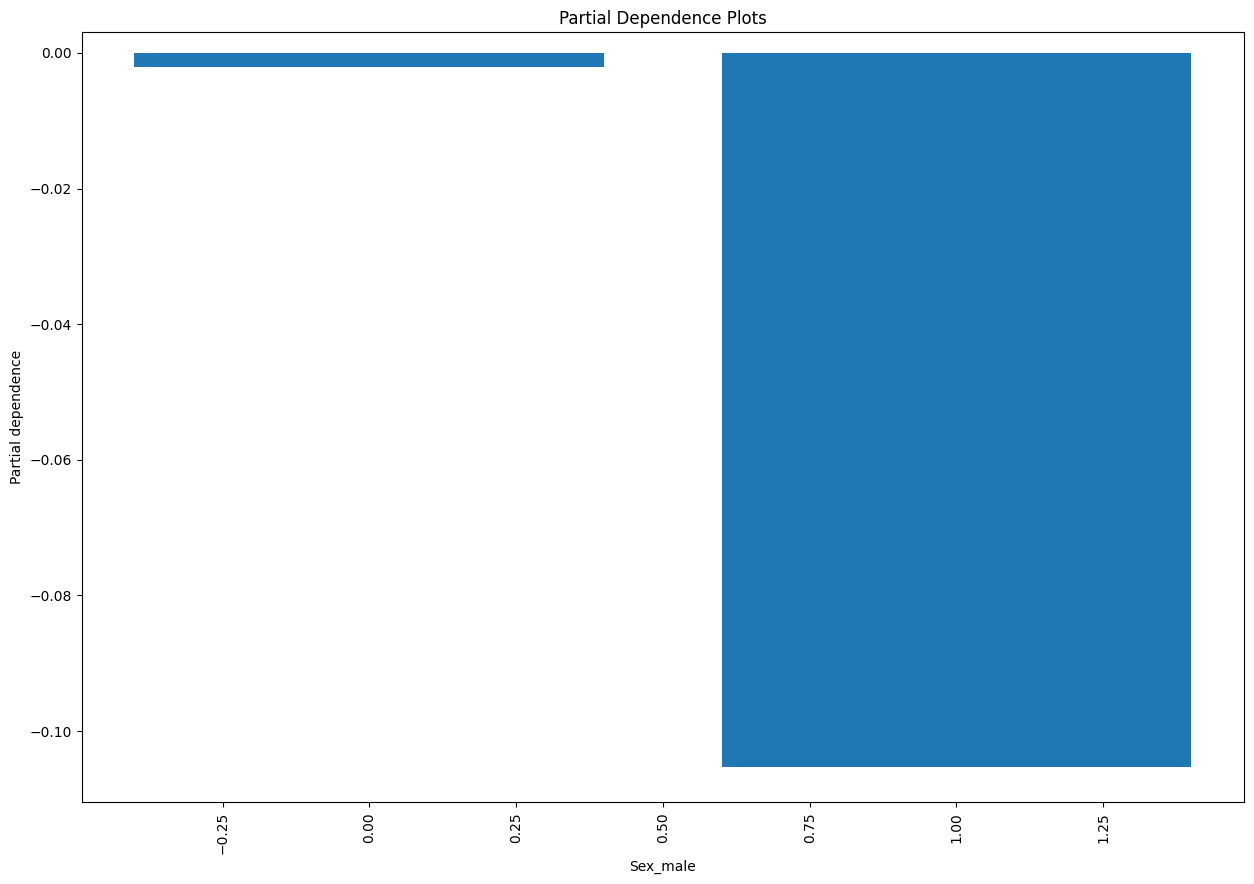

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Partial Dependence Plots")
PartialDependenceDisplay.from_estimator(
    estimator=clf,
    X=X,
    features=[6], # the features to plot
    categorical_features = [6], # categorical features
    random_state=5,
    ax=ax,
)
plt.show()

### Random Forest

In [14]:
clf=rf_clf

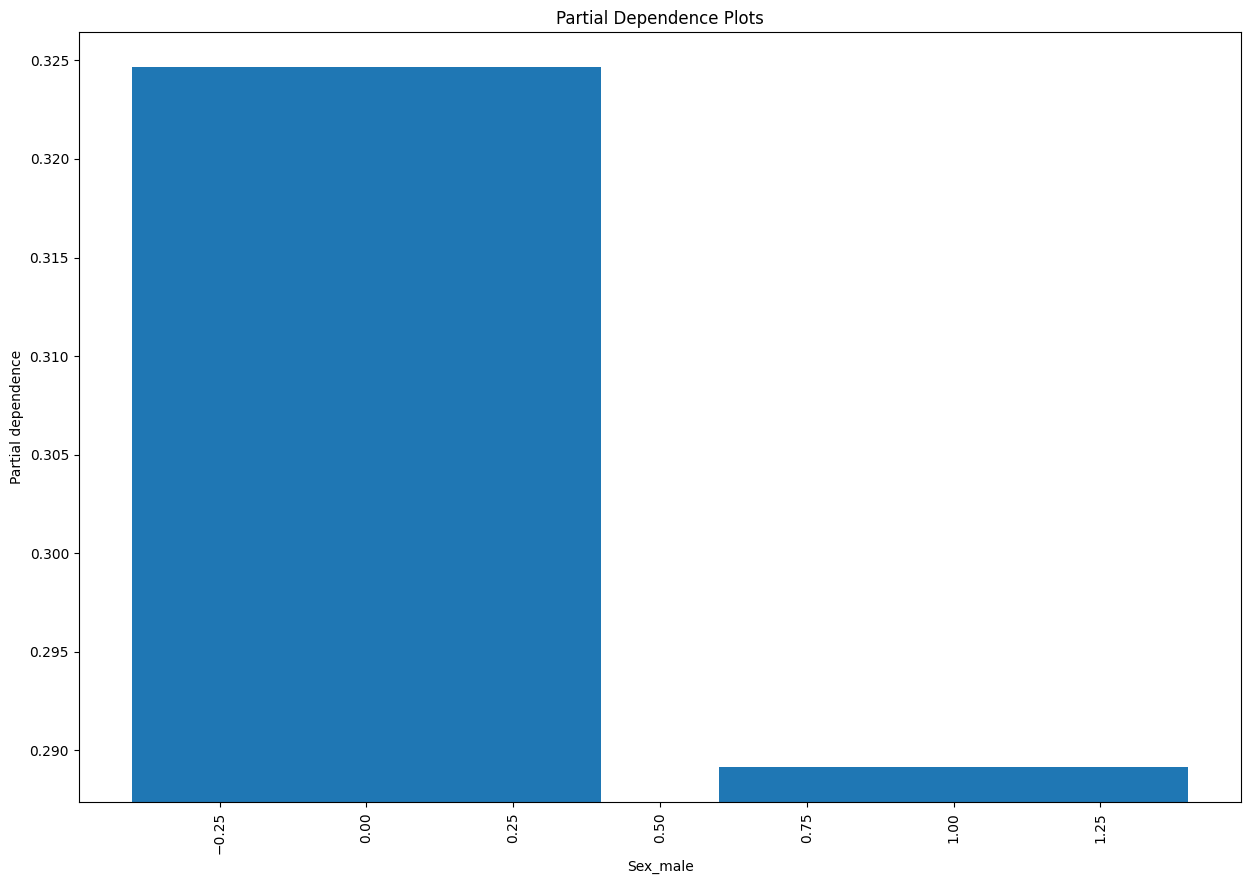

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Partial Dependence Plots")
PartialDependenceDisplay.from_estimator(
    estimator=clf,
    X=X,
    features=[6], # the features to plot
    categorical_features = [6], # categorical features
    random_state=5,
    ax=ax,
)
plt.show()

### Red Neruonal

In [16]:
clf=mlp_clf

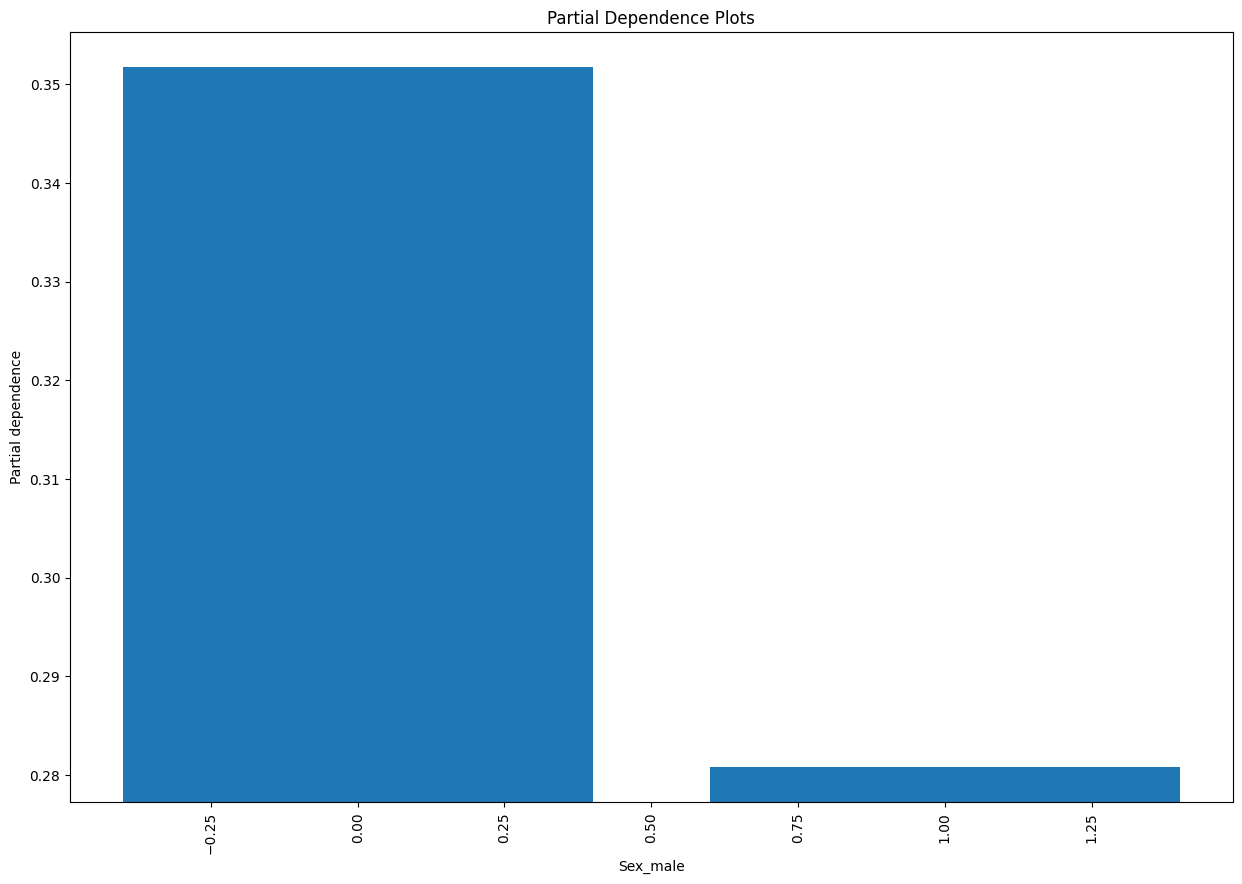

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Partial Dependence Plots")
PartialDependenceDisplay.from_estimator(
    estimator=clf,
    X=X,
    features=[6], # the features to plot
    categorical_features = [6], # categorical features
    random_state=5,
    ax=ax,
)
plt.show()

## SHAP

In [19]:
import shap

In [20]:
shap.initjs()

### Random Forest

In [70]:
clf=rf_clf
clf

RandomForestClassifier(max_depth=11, min_samples_leaf=4, min_samples_split=10)

In [71]:
import shap
import pickle
import numpy as np

# Sample 1000 background data samples
background_samples = shap.sample(X_test, 50)

# Guardar los datos de fondo
np.save('SHAP_rf/background_samples.npy', background_samples)

# Create the explainer
explainer = shap.KernelExplainer(clf.predict_proba, background_samples)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Guardar el explainer y los SHAP values
with open('SHAP_rf/explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)

np.save('SHAP_rf/shap_values.npy', shap_values)

100%|██████████| 200/200 [04:43<00:00,  1.42s/it]


In [72]:
import pickle
import numpy as np

# Cargar los datos de fondo
background_samples = np.load('SHAP_rf/background_samples.npy')

# Cargar el explainer
with open('SHAP_rf/explainer.pkl', 'rb') as f:
    explainer = pickle.load(f)

# Cargar los SHAP values
shap_values = np.load('SHAP_rf/shap_values.npy')


In [73]:
shap.initjs()

Visualización general de los valores SHAP.

In [74]:
clf.feature_names_in_

array(['Age', 'Credit amount', 'Duration', 'Job_1', 'Job_2', 'Job_3',
       'Sex_male', 'Housing_own', 'Housing_rent', 'Saving accounts_1',
       'Saving accounts_2', 'Saving accounts_3', 'Checking account_1',
       'Checking account_2', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment',
       'Purpose_radio/TV', 'Purpose_repairs', 'Purpose_vacation/others'],
      dtype=object)

In [75]:
# Definir nombres de características y etiquetas de destino (cáncer como ejemplo)
feature_names = ['Age', 'Credit amount', 'Duration', 'Job_1', 'Job_2', 'Job_3',
       'Sex_male', 'Housing_own', 'Housing_rent', 'Saving accounts_1',
       'Saving accounts_2', 'Saving accounts_3', 'Checking account_1',
       'Checking account_2', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment',
       'Purpose_radio/TV', 'Purpose_repairs', 'Purpose_vacation/others']  # Lista de nombres de características
target_names = ['y_yes']   # Lista de nombres de etiquetas objetivo

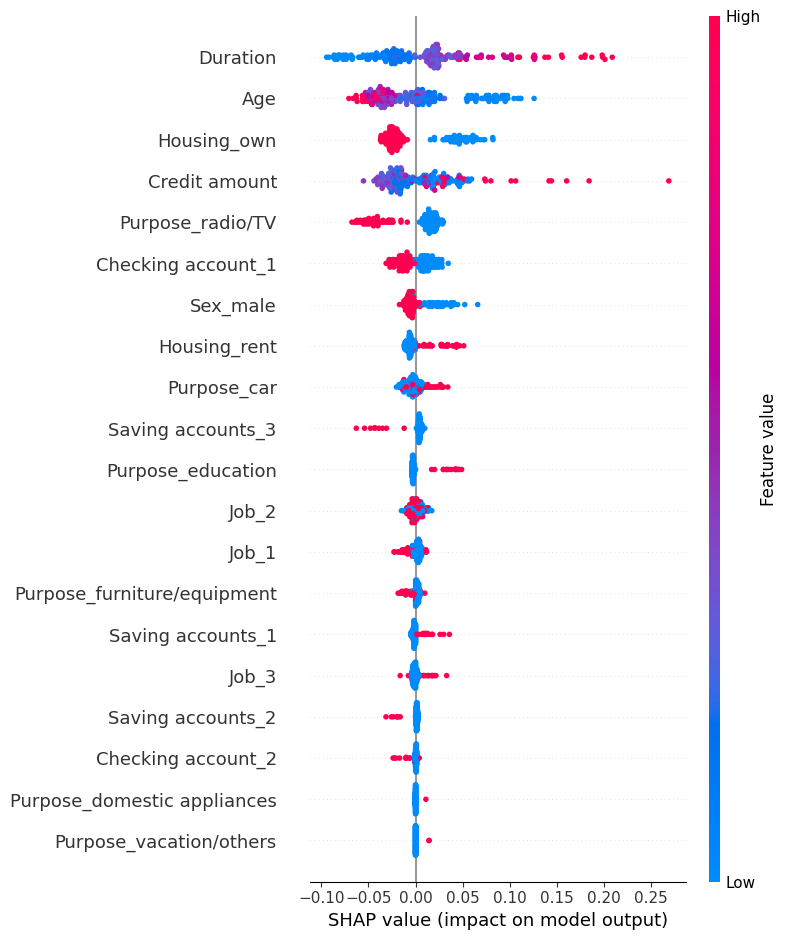

In [76]:
i=1
shap.summary_plot(shap_values[i], features=X_test, 
                   feature_names=feature_names)

Vemos como la variable del género afecta a la predicción de manera muy clara. Aunque los valores shapley no son demasiado altos, claramente nuestro modelo sesga en función del género.

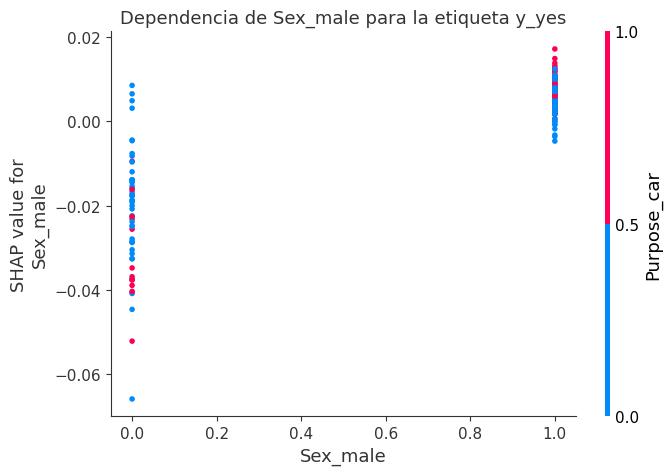

In [77]:
# Visualizar gráficos de dependencia solo para la variable 'Sex_male'
feature_of_interest = 'Sex_male'
feature_index = feature_names.index(feature_of_interest)

for target_label, target_name in enumerate(target_names):
    shap.dependence_plot(
        feature_index,
        shap_values[target_label],
        features=X_test,
        feature_names=feature_names,
        title=f"Dependencia de {feature_of_interest} para la etiqueta {target_name}"
    )

plt.show()

Vamos a observar una serie de datos para estudiar porque sucede lo que sucede.

In [3]:
data = pd.read_csv("../../../GermanRisk/german_credit_data.csv")
data.drop('Unnamed: 0', axis=1, inplace = True)
data['Risk'] = data['Risk'].replace({'good': False, 'bad': True})

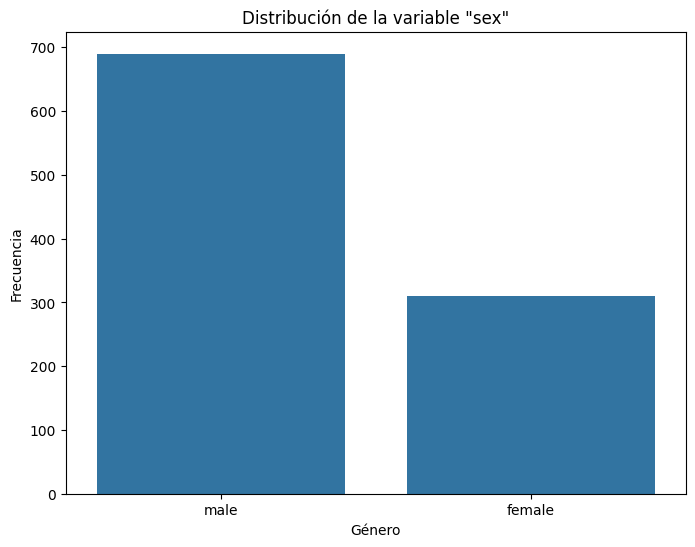

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


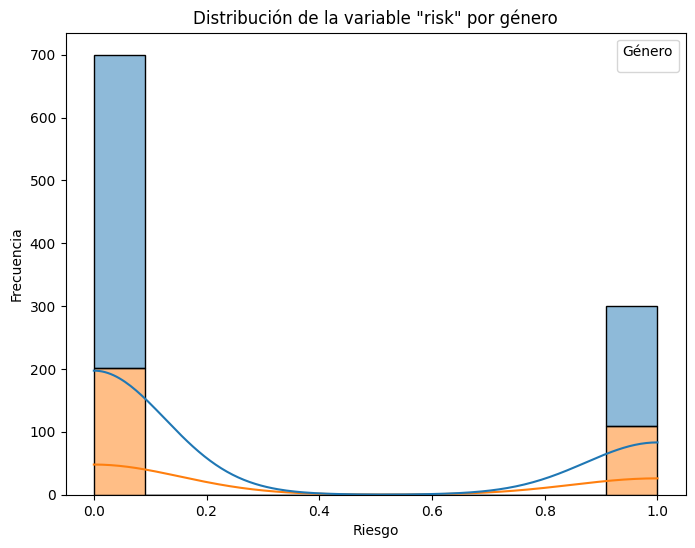

Tabla de contingencia (Género vs Riesgo):
Risk    False  True 
Sex                 
female    201    109
male      499    191


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que ya tienes un DataFrame llamado 'data'

# Gráfico de barras para la variable 'sex'
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', data=data)
plt.title('Distribución de la variable "sex"')
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de densidad o histograma para la variable 'risk' según el género
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='Risk', hue='Sex', multiple='stack', kde=True)
plt.title('Distribución de la variable "risk" por género')
plt.xlabel('Riesgo')
plt.ylabel('Frecuencia')
plt.legend(title='Género')
plt.show()

import pandas as pd

# Calcular la tabla de contingencia
contingency_table = pd.crosstab(index=data['Sex'], columns=data['Risk'])

print("Tabla de contingencia (Género vs Riesgo):")
print(contingency_table)



Vemos de primeras dos cosas importantes:
- Tenemos más datos de hombres.
- Los datos que tenemos están algo descompensados por el género.

Vamos a ver las cantidades medias por género y riesgo.

/tmp/ipykernel_13257/2803263868.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sex', y='Credit amount', hue='Risk', data=data, ci=None)


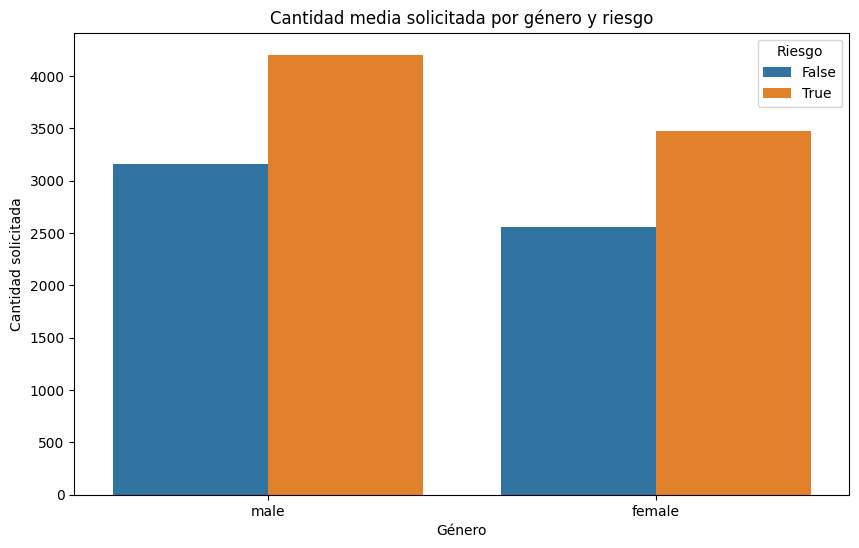

Media de cantidad de crédito solicitado por género y riesgo:
Sex     Risk 
female  False    2555.975124
        True     3471.183486
male    False    3158.454910
        True     4204.602094
Name: Credit amount, dtype: float64


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un gráfico de barras apilado
plt.figure(figsize=(10, 6))
sns.barplot(x='Sex', y='Credit amount', hue='Risk', data=data, ci=None)
plt.title('Cantidad media solicitada por género y riesgo')
plt.xlabel('Género')
plt.ylabel('Cantidad solicitada')
plt.legend(title='Riesgo')
plt.show()

# Calcular la media de cantidad de crédito solicitado por género y riesgo
media_credito_por_genero_riesgo = data.groupby(['Sex', 'Risk'])['Credit amount'].mean()

print("Media de cantidad de crédito solicitado por género y riesgo:")
print(media_credito_por_genero_riesgo)


Vemos que las cantidades medias de crédito son más bajas para las mujeres, es decir, no solo tenemos menos datos de mujeres sino que estos datos representan una menor cantidad del crédito.

Vamos a observar las cantidades totales.

/tmp/ipykernel_12273/649800279.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sex', y='Credit amount', hue='Risk', data=data, estimator=sum, ci=None)


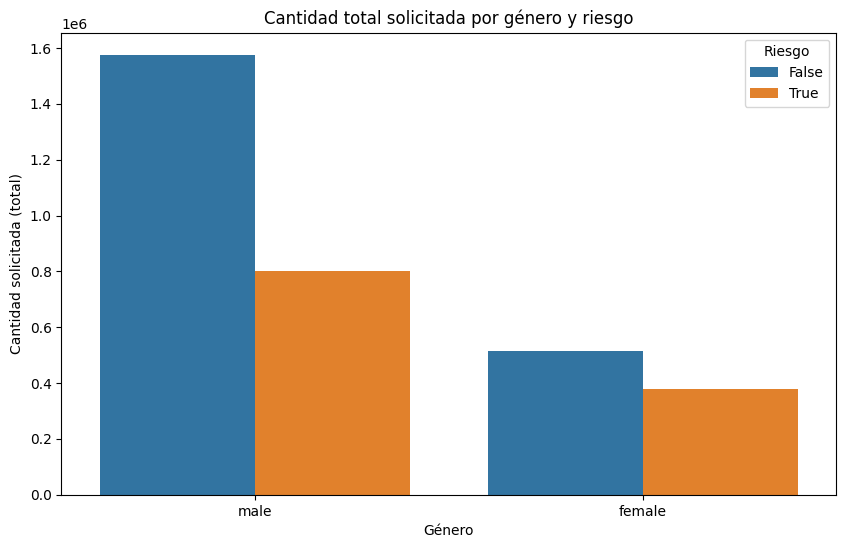

Total de cantidad de crédito solicitado por género y riesgo:
Sex     Risk 
female  False     513751
        True      378359
male    False    1576069
        True      803079
Name: Credit amount, dtype: int64


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un gráfico de barras apilado
plt.figure(figsize=(10, 6))
sns.barplot(x='Sex', y='Credit amount', hue='Risk', data=data, estimator=sum, ci=None)
plt.title('Cantidad total solicitada por género y riesgo')
plt.xlabel('Género')
plt.ylabel('Cantidad solicitada (total)')
plt.legend(title='Riesgo')
plt.show()

# Calcular el total de cantidad de crédito solicitado por género y riesgo
total_credito_por_genero_riesgo = data.groupby(['Sex', 'Risk'])['Credit amount'].sum()

print("Total de cantidad de crédito solicitado por género y riesgo:")
print(total_credito_por_genero_riesgo)


Vemos que efectivamente tenemos un problema, la cantidad de crédito que solicitan las mujeres representa menos de un tercio del total y además está desbalanceada en comparación con la de los hombres.

Comentarios:
- Veremos que la cantidad del crédito afecta al riesgo de ahí que se explique que el género acabe afectando al riesgo.

# ANEXOS

## KERAS

In [ ]:
import keras

model = keras.Sequential(
    [
        keras.layers.Dense(units=9, activation="relu", input_shape=(X_train.shape[-1],) ),
        # randomly delete 30% of the input units below
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units=9, activation="relu"),
        # the output layer, with a single neuron
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

# save the initial weights for later
initial_weights = model.get_weights()

learning_rate = 0.001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss="binary_crossentropy", 
              metrics=keras.metrics.AUC()
             )

history = model.fit(X_train, y_train, 
          epochs=500, 
          batch_size=1000, 
          validation_data=(X_test, y_test))

Epoch 1/500
1/1 [==============================] - 1s 795ms/step - loss: 0.6987 - auc_2: 0.3974 - val_loss: 0.6907 - val_auc_2: 0.3788
Epoch 2/500
1/1 [==============================] - 0s 42ms/step - loss: 0.6801 - auc_2: 0.4324 - val_loss: 0.6882 - val_auc_2: 0.3808
Epoch 3/500
1/1 [==============================] - 0s 28ms/step - loss: 0.6908 - auc_2: 0.4046 - val_loss: 0.6857 - val_auc_2: 0.3818
Epoch 4/500
1/1 [==============================] - 0s 29ms/step - loss: 0.6895 - auc_2: 0.3961 - val_loss: 0.6834 - val_auc_2: 0.3806
Epoch 5/500
1/1 [==============================] - 0s 31ms/step - loss: 0.6770 - auc_2: 0.4278 - val_loss: 0.6810 - val_auc_2: 0.3815
Epoch 6/500
1/1 [==============================] - 0s 30ms/step - loss: 0.6711 - auc_2: 0.4427 - val_loss: 0.6788 - val_auc_2: 0.3815
Epoch 7/500
1/1 [==============================] - 0s 43ms/step - loss: 0.6732 - auc_2: 0.4375 - val_loss: 0.6765 - val_auc_2: 0.3826
Epoch 8/500
1/1 [==============================] - 0s 30ms/st

In [ ]:
history.history.keys()

dict_keys(['loss', 'auc_1', 'val_loss', 'val_auc_1'])

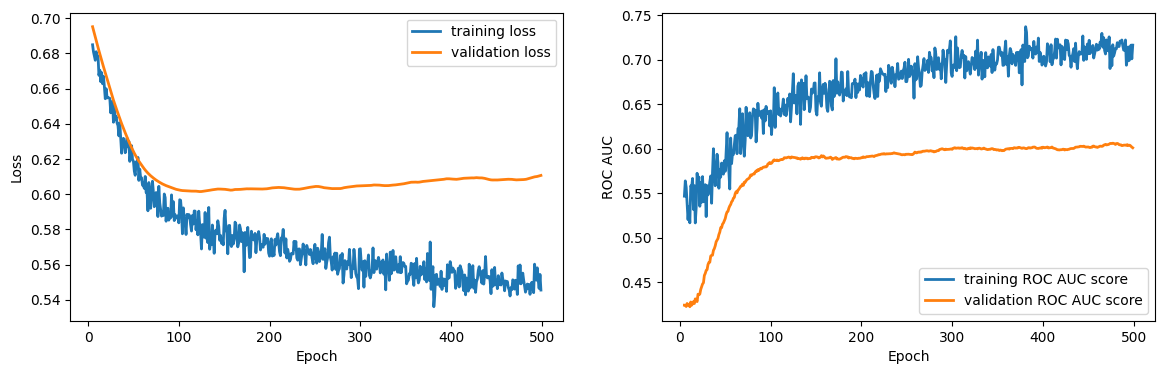

In [ ]:
import matplotlib.pyplot as plt

logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc_1"], lw=2, label='training ROC AUC score')
plt.plot(logs.loc[5:,"val_auc_1"], lw=2, label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.show()

In [ ]:
clf=model

32/32 [==============================] - 0s 940us/step


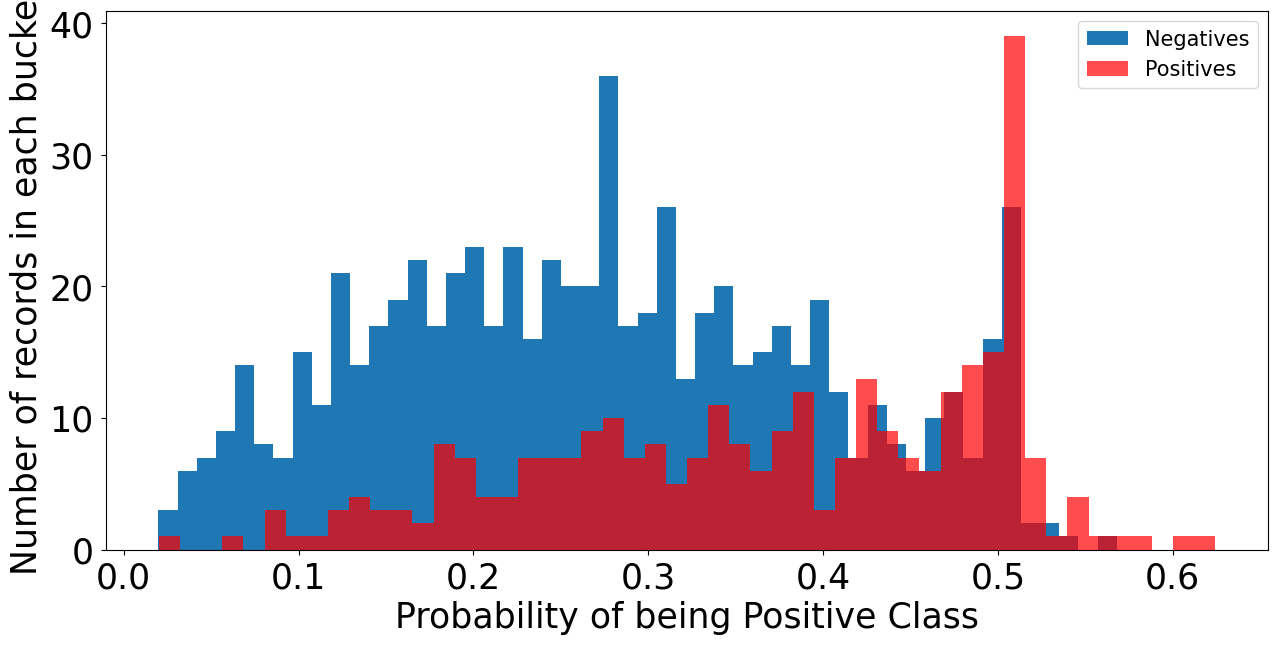

In [ ]:
import Umbrales
Umbrales.plot_prob_keras(clf, X, y)

32/32 [==============================] - 0s 1ms/step

Precisión con umbral nuevo: 0.725
Informe de clasificación con umbral nuevo:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       700
           1       0.55      0.46      0.50       300

    accuracy                           0.73      1000
   macro avg       0.67      0.65      0.65      1000
weighted avg       0.71      0.72      0.72      1000



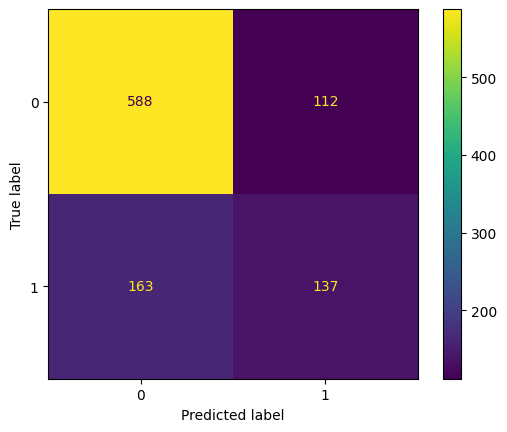

In [ ]:
Umbrales.report_umbral_keras(0.41, clf, X, y)

SIGO OBTENIENDO MALOS RESULTADOS CON KERAS, ME QUEDO FINALMENTE CON MLP.

# Prueba

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Cargar los datos
data = pd.read_csv("GermanRisk/GermanRisk/german_credit_data.csv")

# Manejar los valores faltantes
imputer = SimpleImputer(strategy="most_frequent")
data["Saving accounts"] = imputer.fit_transform(data[["Saving accounts"]])[:, 0]  # Corrección aquí
data["Checking account"] = imputer.fit_transform(data[["Checking account"]])[:, 0]  # Corrección aquí

# Codificar las variables categóricas
label_encoder = LabelEncoder()
data["Sex"] = label_encoder.fit_transform(data["Sex"])
data["Housing"] = label_encoder.fit_transform(data["Housing"])
data["Saving accounts"] = label_encoder.fit_transform(data["Saving accounts"])
data["Checking account"] = label_encoder.fit_transform(data["Checking account"])
data["Purpose"] = label_encoder.fit_transform(data["Purpose"])
data["Risk"] = label_encoder.fit_transform(data["Risk"])

# Escalar las características numéricas
scaler = StandardScaler()
data[["Age", "Credit amount", "Duration"]] = scaler.fit_transform(data[["Age", "Credit amount", "Duration"]])


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

# Dividir los datos en características (X) y etiquetas (y)
X = data.drop('Risk', axis=1)  # Características
y = data['Risk']  # Etiquetas

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de red neuronal
modelo = Sequential()
modelo.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Capa oculta con 64 neuronas y función de activación ReLU
modelo.add(Dense(1, activation='sigmoid'))  # Capa de salida con 1 neurona y función de activación sigmoide

# Compilar el modelo
modelo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
modelo.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo
puntuacion = modelo.evaluate(X_test, y_test)
print("Precisión del modelo: %.2f%%" % (puntuacion[1] * 100))

nt_clf=modelo

Epoch 1/10
25/25 [==============================] - 1s 7ms/step - loss: 13.5279 - accuracy: 0.5987 - val_loss: 1.1813 - val_accuracy: 0.3100
Epoch 2/10
25/25 [==============================] - 0s 2ms/step - loss: 2.2197 - accuracy: 0.5987 - val_loss: 2.2951 - val_accuracy: 0.7150
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 1.3368 - accuracy: 0.5813 - val_loss: 0.6501 - val_accuracy: 0.6550
Epoch 4/10
25/25 [==============================] - 0s 2ms/step - loss: 0.6784 - accuracy: 0.6612 - val_loss: 0.6392 - val_accuracy: 0.6600
Epoch 5/10
25/25 [==============================] - 0s 2ms/step - loss: 0.6254 - accuracy: 0.6825 - val_loss: 0.7092 - val_accuracy: 0.5350
Epoch 6/10
25/25 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6737 - val_loss: 0.6225 - val_accuracy: 0.6600
Epoch 7/10
25/25 [==============================] - 0s 3ms/step - loss: 0.6095 - accuracy: 0.6938 - val_loss: 0.6501 - val_accuracy: 0.7100
Epoch 8/10
25/25 [=

32/32 [==============================] - 0s 904us/step


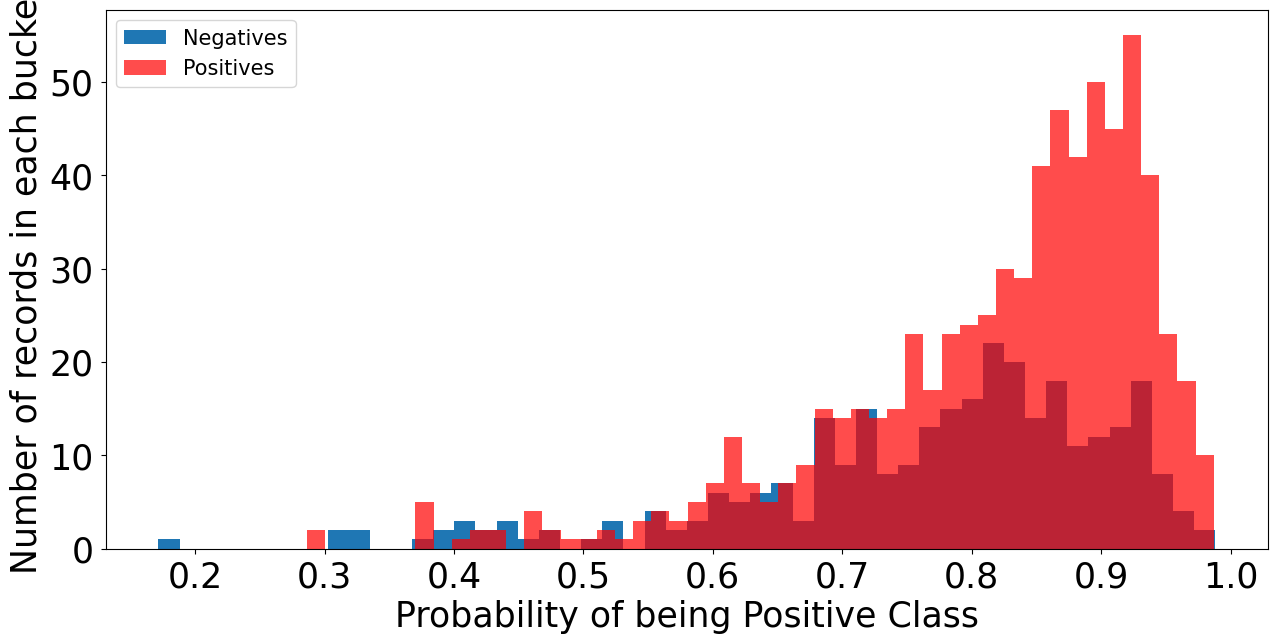

In [ ]:
Umbrales.plot_prob_keras(nt_clf, X, y)

In [ ]:
Umbrales.report_umbral_keras(0.49, clf, X, y)

32/32 [==============================] - 0s 1ms/step

Precisión con umbral nuevo: 0.73
Informe de clasificación con umbral nuevo:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       700
           1       0.63      0.25      0.35       300

    accuracy                           0.73      1000
   macro avg       0.69      0.59      0.59      1000
weighted avg       0.71      0.73      0.69      1000



AttributeError: 'Sequential' object has no attribute 'classes_'